# General setting

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# started at https://www.kaggle.com/renataghisloti
# %-m pip install --upgrade pip
# %pip install pandas 
# %pip install seaborn
# %pip install matplotlib
# %pip install xgboost
# %pip install lightgbm
# %pip install sklearn
# %pip install "tensorflow<2.11"
# %pip install catboost
import time
import numpy as np # yLinear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")
import random
import os
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split
import xgboost as xg
import lightgbm as lgb
from sklearn.metrics import log_loss
# #https://www.tensorflow.org/install
# # Requires the latest pip
# # !-m pip install --upgrade pip
# # Current stable release for CPU and GPU
# # !pip install tensorflow
# #Testing if tensorflow is installed
import tensorflow as tf 
from tensorflow import keras 
# print('tf.__version__: ', tf.__version__)
# print('__version__: ', keras.__version__)
from sklearn.base import BaseEstimator, TransformerMixin

random.seed(42)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
isInKaggle = not os.environ['PATH'].startswith('c:')#It is local if True ;)

DATA_ROOT = "/kaggle/input/icr-identify-age-related-conditions/" if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/data/ageRelatedConditions/"
PREPROCESSED_DATA_ROOT = "/kaggle/input/preprocessed/" if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/data/ageRelatedConditions/"
RESULTS_ROOT = '/kaggle/working/' if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/results/ageRelatedConditions/"

# Input train files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk(DATA_ROOT):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# u1 = 0; u2 = 1; 
u = 'Class'
initialModelsObjs = {}; errorModelsObjs = {}

In [5]:
#from https://www.tensorflow.org/install/pip?hl=pt-br#windows-native
# %conda install -c conda-forge cudatoolkit=11.8.0
#....
# # %pip install --upgrade pip
print('tf.__version__: ', tf.__version__)
# %pip install tensorflow-gpu
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

tf.__version__:  2.10.1
Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11048519229905195581
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1734816564
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8326164378183510517
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [6]:
#constants
CombMVMaxLogLoss_dif_vt = .1
# isToModel = True
outlierProbability = None#.5; #None for not using outlier-variables
dataSubsetsProps = [.25, .50, .75, .25] #proportion of patients to each modeling phase and test phase;
isWithOptimization = False; 
isWithPCA = False; 
TfBatchSize = 35 if isInKaggle else 35; 
TfVerbose = False if isInKaggle else False;
TfEpochs = 5000 if isInKaggle else 5000; 
TfPatience = 10
nImportantFeatures = 56;#there are 56 predictor variables;
nPcaComponents = np.min([20, nImportantFeatures])# there are 56 predictor variables;
myCv = 5 if not isInKaggle else 50;
openMinimalTreshold = -1 #only values greater than openMinimalTreshold are considered in the modeling; 
optMethod = 'GridSearchCV'#'BayesSearchCV'
PRED_PREFIX = ''#'pe'#'pr'

In [7]:
# Models Architecture Compilation
import joblib
MODELS_ROOT = "/kaggle/input/"+PRED_PREFIX + \
    'models3/' if isInKaggle else "C:/Users/praf6/OneDrive - Universidade Federal do Cariri - UFCA/Drive/UFCA/Ensino/CRAN R_aulas/kaggleFiles/results/ageRelatedConditions/"+PRED_PREFIX
def foldersVerification(ROOT):
    def computeFolder(root, folder):
        path = root + folder
        if not os.path.exists(path):
            os.makedirs(path)
        return path
    ROOT_ = computeFolder(ROOT, 'Models/')
    ROOT_ = computeFolder(ROOT_, 'withPCA/' if isWithPCA else 'withoutPCA/')
    ROOT_ = computeFolder(
        ROOT_, 'withOptimization/' if isWithOptimization else 'withoutOptimization/')
    return ROOT_
MODELS_ROOT = foldersVerification(MODELS_ROOT)
PERFORMANCE_ROOT = foldersVerification(RESULTS_ROOT+'Wperformance/')
def getModelName(yModel, eModel=None, targetVar=""):
    type_yModel = type(yModel)
    yModelNm = yModel if type_yModel == str else 'y'+type_yModel.__name__
    formalism = yModelNm.replace('Classifier', '').replace('Classification', '').replace(
        'Regressor', '').replace('Regression', '')  # .replace('yy', 'y')
    if eModel is not None:
        type_eModel = type(eModel)
        eModelNm = eModel if type_eModel == str else type_eModel.__name__
        # replace('Classifier', '').replace('Classification', '')
        formalism += '_e' + \
            eModelNm.replace('Regressor', '').replace('Regression', '')
    # if targetVar != "": formalism += ('_'+targetVar)
    return formalism
class MyEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, targetVar=None, saveExtension='.sav', model=None,
                 xVarsNms=None):
        self.targetVar = targetVar
        self.model = model
        self.xVarsNms = xVarsNms
        self.saveExtension = saveExtension
        self.xVarsNms = xVarsNms
    def loadModel(self, path):
        try:
            # the usual function for sklearn models
            self.model = joblib.load(path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            # the usual function for sklearn models
            self.model = joblib.load(path2)

        return self.model
    def saveModel(self, path):
        try:
            # the usual function for sklearn models
            joblib.dump(self.model, path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            joblib.dump(self.model, path2)
        return self
    def fit(self, X, y, modelName=None):
        if isWithOptimization:
            self.model.fit(X, y)
        else:
            modelNm = modelName if modelName is not None else getModelName(
                self, targetVar=self.targetVar)
            path = MODELS_ROOT+modelNm+self.saveExtension
            start = time.time()
            try:
                self.model = self.loadModel(path)
                print('==**** load_model', modelNm, '****==')
            except:
                print('==**** fit', modelNm, '****==')
                # X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, shuffle=False)
                # eval_set = [(X_validation, y_validation)]
                # , eval_metric="binary:logistic", eval_set=eval_set, early_stopping_rounds=10,
                self.model.fit(X, y)
                self.saveModel(path)
            print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self
class MyClassifier(MyEstimator):
    def predict(self, X):
        # the usual function for sklearn classiifers
        ret = self.model.predict_proba(X)[:, 1]
        # if not isWithOptimization:
        # ret = ret[:,1]#[v[1] for v in ret0]
        # ret = list(np.concatenate(ret, axis=0 ))
        return ret  # .tolist()
    # def transform(self, X):
    #     return self
class MyRegressor(MyEstimator):
    def predict(self, X):
        # the usual function for sklearn regressors
        ret = self.model.predict(X)
        # if not isWithOptimization:
        # ret = ret[:,1]#[v[1] for v in ret0]
        # ret = list(np.concatenate(ret, axis=0 ))
        return ret.tolist()
class MyTfANN (MyEstimator):
    def __init__(self, targetVar, phase, hidden_layer_sizes=(2, 2, 2),
                 hidden_layer_dropout_rates=(.2, .2, .2),
                 hidden_layer_activations=('relu', 'relu', 'relu'),
                 learningRate=3e-3,
                 inpute_layer_dropout_rate=.2,
                 hidden_layer_functions=[keras.layers.Dense],
                 outputActivationFunction='linear',  # 'sigmoid'
                 loss='rmse',
                 batch_size=1):
        self.targetVar = targetVar
        self.phase = phase
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learningRate = learningRate
        self.inpute_layer_dropout_rate = inpute_layer_dropout_rate
        self.hidden_layer_activations = hidden_layer_activations
        self.hidden_layer_functions = hidden_layer_functions
        self.outputActivationFunction = outputActivationFunction
        self.loss = loss
        self.batch_size = batch_size
        # Model architecture
        self.model = self.getTfAnnModelStructure(
            hidden_layer_sizes=hidden_layer_sizes,
            hidden_layer_dropout_rates=hidden_layer_dropout_rates,
            hidden_layer_activations=hidden_layer_activations,
            learningRate=learningRate,
            inpute_layer_dropout_rate=inpute_layer_dropout_rate,
            hidden_layer_functions=hidden_layer_functions,
            outputActivationFunction=outputActivationFunction,
            loss=loss)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.keras', xVarsNms=None)
    def getTfAnnModelStructure(self, targetVar=None, hidden_layer_sizes=(2, 2, 2),
                               hidden_layer_dropout_rates=(.2, .2, .2),
                               hidden_layer_activations=(
                                   'relu', 'relu', 'relu'),
                               learningRate=3e-3,
                               inpute_layer_dropout_rate=.2,
                               hidden_layer_functions=[keras.layers.Dense],
                               outputActivationFunction='linear',  # 'sigmoid'
                               loss='rmse'):  # 'log_loss'
        # Model architecture
        tfAnn_reg = keras.models.Sequential(name="TF_ANN")
        multi = 1 if outlierProbability is None else 3  # due to the two outliers columns
        u = targetVar
        input_shape = None
        if str(hidden_layer_functions[0]) == "<class 'keras.layers.core.dense.Dense'>":
            input_shape = (nPcaComponents*multi,
                           ) if isWithPCA else (nImportantFeatures*multi,)
        elif str(hidden_layer_functions[0]) == "<class 'keras.layers.rnn.lstm.LSTM'>":
            # (1, nPcaComponents*multi, ) if isWithPCA else (1, nImportantFeatures*multi, )#to evolve ;)
            input_shape = [None, 1]
        tfAnn_reg.add(keras.layers.InputLayer(
            name="input_layer", input_shape=input_shape))
        if inpute_layer_dropout_rate > 0:
            tfAnn_reg.add(keras.layers.Dropout(
                inpute_layer_dropout_rate))  # dropout
        nHiddenLayers = len(hidden_layer_sizes)
        nDropouts = len(hidden_layer_dropout_rates)
        nActivations = len(hidden_layer_activations)
        n_hidden_layer_functions = len(hidden_layer_functions)
        if nHiddenLayers > 1 and nDropouts == 1:
            hidden_layer_dropout_rates = tuple(
                [hidden_layer_dropout_rates[0]]*nHiddenLayers)
        if nHiddenLayers > 1 and nActivations == 1:
            hidden_layer_activations = tuple(
                [hidden_layer_activations[0]]*nHiddenLayers)
        if nHiddenLayers > 1 and n_hidden_layer_functions == 1:
            hidden_layer_functions = tuple(
                [hidden_layer_functions[0]]*nHiddenLayers)
        for i in range(nHiddenLayers):
            if str(hidden_layer_functions[i]) == "<class 'keras.layers.core.dense.Dense'>":
                tfAnn_reg.add(hidden_layer_functions[i](name=("hidden_layer_" + str(i)),
                                                        units=hidden_layer_sizes[i],
                                                        activation=hidden_layer_activations[i]))  # hidden layer # i
                if hidden_layer_dropout_rates[i] > 0:
                    tfAnn_reg.add(keras.layers.Dropout(
                        hidden_layer_dropout_rates[i]))
            elif str(hidden_layer_functions[i]) == "<class 'keras.layers.rnn.lstm.LSTM'>":
                return_sequences = True if i < (nHiddenLayers-1) else False
                tfAnn_reg.add(hidden_layer_functions[i](name=("hidden_layer_" + str(i)),
                                                        units=hidden_layer_sizes[i],
                                                        recurrent_dropout=hidden_layer_dropout_rates[i],
                                                        return_sequences=return_sequences))  # hidden layer # i

        # outputActivationFunction = 'sigmoid' if type=='Classifier' else 'linear'
        tfAnn_reg.add(keras.layers.Dense(name="output_layer", units=1,
                      activation=outputActivationFunction))  # output layer 'linear' 'softmax'
        optimizer = keras.optimizers.SGD(learning_rate=learningRate)
        tfAnn_reg.compile(loss=loss, optimizer=optimizer,
                          metrics='mae')
        return (tfAnn_reg)
    def loadModel(self, path):
        try:
            # the usual function for keras models
            self.model = keras.models.load_model(path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            self.model = keras.models.load_model(path2)
        return self.model
    def saveModel(self, path):
        try:
            self.model.save(path)  # the usual function for keras models
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            self.model.save(path2)
        return self
    def fit(self, X, y, modelName=None):
        if isWithOptimization:
            self.model.fit(X, y)
        else:
            # self.targetVar + '_' + self.phase + '_' + type(self).__name__.replace('Classifier', '')
            modelNm = modelName if modelName is not None else getModelName(
                self, targetVar=self.targetVar)
            path = MODELS_ROOT+modelNm+self.saveExtension
            start = time.time()
            try:
                self.model = self.loadModel(path)
                print('==**** load_model', modelNm, '****==')
            except:
                print('==****', modelNm, '****==')
                early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                                  patience=TfPatience,
                                                                  restore_best_weights=True)

                # reshape input to be [samples, time steps, features]
                # np.reshape(X, (X.shape[0], 1, X.shape[1]))#to evolve with this... ;)
                rX = X
                history = self.model.fit(rX, y, epochs=TfEpochs,
                                         batch_size=self.batch_size,
                                         validation_split=.2,
                                         verbose=TfVerbose, callbacks=[early_stopping_cb])
                epochsLastIndex = len(history.epoch)-1
                LogLoss_t = np.round(
                    (history.history['loss'][epochsLastIndex]), 3)
                LogLoss_v = np.round(
                    (history.history['val_loss'][epochsLastIndex]), 3)
                MAE_t = np.round(history.history['mae'][epochsLastIndex], 3)
                MAE_v = np.round(
                    history.history['val_mae'][epochsLastIndex], 3)
                LogLoss_v_t = LogLoss_v - LogLoss_t
                MAE_v_t = MAE_v - MAE_t
                df = pd.DataFrame({'convergenceEpoch': history.epoch[epochsLastIndex],
                                   'MSE_t': LogLoss_t, 'MSE_v': LogLoss_v, 'MSE_v_t': LogLoss_v_t,
                                   'MAE_t': MAE_t, 'MAE_v': MAE_v, 'MAE_v_t': MAE_v_t}, index=[0])
                display(df)
                self.saveModel(path)
            print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self
    def predict(self, X):
        ret = self.model.predict(X, verbose=False)
        ret = list(np.concatenate(ret, axis=0))
        return ret
class MyXGB (MyEstimator):
    def __init__(self, targetVar=None, colsample_bytree=1, eta=0.3, max_depth=6, n_estimators=100,
                 objective='reg:squarederror', seed=0, subsample=1, gamma=0, model=None,
                 eval_metric = 'rmse',
                 learning_rate = 0.413327571405248,
                booster = 'gbtree',
                reg_lambda = 0.0000263894617720096,
                alpha = 0.000463768723479341,
                min_child_weight = 9,
                grow_policy = 'depthwise',
                n_jobs = -1,
                verbosity = 0):#logloss 
        self.targetVar = targetVar
        self.colsample_bytree = colsample_bytree
        self.eta = eta
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.subsample = subsample
        self.objective = objective
        self.seed = seed
        self.model = model
        self.gamma = gamma
        self.eval_metric = eval_metric
        self.learning_rate = learning_rate
        self.booster = booster
        self.reg_lambda = reg_lambda
        self.alpha = alpha
        self.min_child_weight = min_child_weight
        self.grow_policy = grow_policy
        self.n_jobs = n_jobs
        self.verbosity = verbosity
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.txt', xVarsNms=None)

    def loadModel(self, path):
        try:
            self.model.load_model(path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            self.model.load_model(path2)
        return self.model

    def saveModel(self, path):
        try:
            self.model.save_model(path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            self.model.save_model(path2)
        return self

    def fit(self, X, y, modelName=None):
        if isWithOptimization:
            self.model.fit(X, y)
        else:
            # self.targetVar + '_' + self.phase + '_' + type(self).__name__.replace('Classifier', '')
            modelNm = modelName if modelName is not None else getModelName(
                self, targetVar=self.targetVar)
            path = MODELS_ROOT+modelNm+self.saveExtension
            start = time.time()
            try:
                self.model = self.loadModel(path)
                print('==**** load_model', modelNm, '****==')
            except:
                print('==**** fit_model', modelNm, '****==')
                X_train, X_validation, y_train, y_validation = train_test_split(
                    X, y, test_size=0.2, shuffle=False)
                eval_set = [(X_validation, y_validation)]
                self.model.fit(X_train, y_train,
                                  eval_metric=self.eval_metric,
                               eval_set=eval_set,
                               early_stopping_rounds=10,
                               verbose=False)
                self.saveModel(path)
            print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self
class MyLGBM (MyEstimator):
    def __init__(self, targetVar=None, min_split_gain=0,
                 learning_rate=0.1,
                 min_child_samples=20,
                 max_depth=-1,
                 n_estimators=100,
                 random_state=0,
                 num_leaves=31,
                 model=None,
                 eval_metric='rmse'):  # "binary:logistic"
        self.targetVar = targetVar
        self.min_split_gain = min_split_gain
        self.learning_rate = learning_rate
        self.min_child_samples = min_child_samples
        self.max_depth = max_depth
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.num_leaves = num_leaves
        self.model = model
        self.eval_metric = eval_metric
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.txt', xVarsNms=None)

    def loadModel(self, path):
        try:
            self.model = lgb.Booster(model_file=path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            self.model = lgb.Booster(model_file=path2)
        return self.model

    def saveModel(self, path):
        try:
            self.model.booster_.save_model(path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            self.model.booster_.save_model(path2)
        return self

    def fit(self, X, y, modelName=None):
        if isWithOptimization:
            self.model.fit(X, y)
        else:
            # self.targetVar + '_' + self.phase + '_' + type(self).__name__.replace('Classifier', '')
            modelNm = modelName if modelName is not None else getModelName(
                self, targetVar=self.targetVar)
            # if(modelNm == 'yMyXGB_eMyLGBM'):
            #     g=1
            path = MODELS_ROOT+modelNm+self.saveExtension
            start = time.time()
            try:
                self.model = self.loadModel(path)
                print('==**** load_model', modelNm, '****==')
            except:
                print('==**** fit', modelNm, '****==')
                X_train, X_validation, y_train, y_validation = train_test_split(
                    X, y, test_size=0.2, shuffle=False)
                eval_set = [(X_validation, y_validation)]
                
                self.model.fit(X_train, y_train, eval_metric=self.eval_metric, eval_set=eval_set, early_stopping_rounds=10,
                               verbose=False)
                self.saveModel(path)
            print('>>> elapsed time:', str(time.time() - start), 'seconds!')
        return self

# classifiers
class MyLogisticRegression (MyClassifier, LogisticRegression):
    def __init__(self, targetVar=None, tol=0.0001,
                 C=1, fit_intercept=True, intercept_scaling=1,
                 max_iter=100, verbose=False, random_state=0):
        self.targetVar = targetVar
        self.tol = tol
        self.C = C
        self.fit_intercept = fit_intercept
        self.intercept_scaling = intercept_scaling
        self.max_iter = max_iter
        self.verbose = verbose
        self.random_state = random_state

        self.model = LogisticRegression(tol=self.tol,
                                        C=self.C,
                                        fit_intercept=self.fit_intercept,
                                        intercept_scaling=self.intercept_scaling,
                                        max_iter=self.max_iter,
                                        verbose=self.verbose,
                                        random_state=self.random_state)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MySVC (MyClassifier, SVC):
    def __init__(self, targetVar=None,
                 C=1,
                 #  ,
                 coef0=0,
                 degree=3,
                 gamma='scale',
                 kernel='rbf',
                 tol=1e-3):
        self.targetVar = targetVar
        self.C = C
        self.coef0 = coef0
        self.degree = degree
        self.gamma = gamma
        self.kernel = kernel
        self.tol = tol

        self.model = SVC(probability=True,
                         C=self.C,
                         coef0=self.coef0,
                         degree=self.degree,
                         gamma=self.gamma,
                         kernel=self.kernel,
                         tol=self.tol,
                         verbose=False)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyDecisionTreeClassifier (MyClassifier, DecisionTreeClassifier):
    def __init__(self, targetVar=None,
                 ccp_alpha=0,
                 max_depth=None,
                 min_samples_leaf=1,
                 min_samples_split=2,
                 splitter='best'):
        self.targetVar = targetVar
        self.ccp_alpha = ccp_alpha
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.splitter = splitter

        self.model = DecisionTreeClassifier(
            ccp_alpha=self.ccp_alpha,
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            min_samples_split=self.min_samples_split,
            splitter=self.splitter,
            random_state=0)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyRandomForestClassifier (MyClassifier, RandomForestClassifier):
    def __init__(self, targetVar=None,
                 n_estimators=100,
                 ccp_alpha=0,
                 max_depth=None,
                 min_samples_leaf=1,
                 min_samples_split=2):
        self.targetVar = targetVar
        self.n_estimators = n_estimators
        self.ccp_alpha = ccp_alpha
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        self.model = RandomForestClassifier(
            ccp_alpha=self.ccp_alpha,
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            min_samples_split=self.min_samples_split,
            random_state=0)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyHistGBClassifier (MyClassifier, HistGradientBoostingClassifier):
    def __init__(self, targetVar=None, 
                 loss="log_loss",
                learning_rate = 0.1,
                max_iter = 100,
                max_leaf_nodes = 31,
                max_depth = None,
                min_samples_leaf = 20,
                l2_regularization = 0,
                max_bins = 255,
                categorical_features = None,
                monotonic_cst = None,
                interaction_cst = None,
                warm_start = False,
                early_stopping= "auto",
                scoring = "loss",
                validation_fraction = 0.1,
                n_iter_no_change = 10,
                tol = 1e-7,
                verbose = 0,
                random_state = 0,
                class_weight = None):

        self.model = HistGradientBoostingClassifier(loss=loss,
                    learning_rate=learning_rate,
                    max_iter=max_iter,
                    max_leaf_nodes=max_leaf_nodes,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    l2_regularization=l2_regularization,
                    max_bins=max_bins,
                    categorical_features=categorical_features,
                    monotonic_cst=monotonic_cst,
                    interaction_cst=interaction_cst,
                    warm_start=warm_start,
                    early_stopping=early_stopping,
                    scoring=scoring,
                    validation_fraction=validation_fraction,
                    n_iter_no_change=n_iter_no_change,
                    tol=tol,
                    verbose=verbose,
                    random_state=random_state,
                    class_weight=class_weight)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyMLPClassifier (MyClassifier, MLPClassifier):
    def __init__(self, targetVar=None,
                 random_state=0,
                 activation='relu',
                 early_stopping=True,  # False,
                 validation_fraction=.2,  # 0.1,
                 n_iter_no_change=TfPatience,  # 10,
                 batch_size=TfBatchSize,  # "auto",
                 hidden_layer_sizes=(100,),
                 verbose=False, max_iter=200):
        self.targetVar = targetVar
        self.random_state = random_state
        self.activation = activation
        self.hidden_layer_sizes = hidden_layer_sizes
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.verbose = verbose
        self.max_iter = max_iter
        self.model = MLPClassifier(random_state=self.random_state,
                                   activation=self.activation,
                                   hidden_layer_sizes=self.hidden_layer_sizes,
                                   batch_size=self.batch_size,
                                   n_iter_no_change=self.n_iter_no_change,
                                   validation_fraction=self.validation_fraction,
                                   early_stopping=self.early_stopping,
                                   verbose=self.verbose, max_iter=self.max_iter
                                   )
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyTfRNNClassifier (MyTfANN):
    def __init__(self, targetVar, phase, hidden_layer_sizes=(2, 2, 2),
                 hidden_layer_dropout_rates=(.2, .2, .2),
                 hidden_layer_activations=('relu', 'relu', 'relu'),
                 learningRate=3e-3,
                 inpute_layer_dropout_rate=.2):
        MyTfANN.__init__(self=self, targetVar=targetVar,
                         phase=phase,
                         hidden_layer_sizes=hidden_layer_sizes,
                         hidden_layer_dropout_rates=hidden_layer_dropout_rates,
                         hidden_layer_activations=hidden_layer_activations,
                         learningRate=learningRate,
                         inpute_layer_dropout_rate=inpute_layer_dropout_rate,
                         hidden_layer_functions=[keras.layers.LSTM],
                         outputActivationFunction='sigmoid',
                         loss='mse',
                         batch_size=1)
class MyTfMLPClassifier (MyTfANN):
    def __init__(self, targetVar, phase, hidden_layer_sizes=(2, 2, 2),
                 hidden_layer_dropout_rates=(.2, .2, .2),
                 hidden_layer_activations=('relu', 'relu', 'relu'),
                 learningRate=3e-3,
                 inpute_layer_dropout_rate=.2):
        MyTfANN.__init__(self=self, targetVar=targetVar,
                         phase=phase,
                         hidden_layer_sizes=hidden_layer_sizes,
                         hidden_layer_dropout_rates=hidden_layer_dropout_rates,
                         hidden_layer_activations=hidden_layer_activations,
                         learningRate=learningRate,
                         inpute_layer_dropout_rate=inpute_layer_dropout_rate,
                         hidden_layer_functions=[keras.layers.Dense],
                         outputActivationFunction='sigmoid',
                         loss='mse',
                         batch_size=TfBatchSize)
class MyXGBClassifier (MyClassifier, MyXGB):
    def __init__(self, targetVar=None, colsample_bytree=1, eta=0.3, max_depth=6, n_estimators=100,
                 objective='reg:squarederror', seed=0, subsample=1, gamma=0, learning_rate = 0.3,
                booster = 'gbtree',
                reg_lambda = 1,
                alpha = 0,
                min_child_weight = 1,
                grow_policy = 'depthwise',
                n_jobs = -1,
                verbosity = 0):
        self.model = xg.XGBClassifier(colsample_bytree=colsample_bytree,
                                      eta=eta, max_depth=max_depth,
                                      n_estimators=n_estimators, subsample=subsample,
                                      objective=objective, seed=seed, gamma=gamma,
                        booster = booster,
                        reg_lambda = reg_lambda,
                        alpha = alpha,
                        min_child_weight = min_child_weight,
                        grow_policy = grow_policy,
                        n_jobs = n_jobs,
                        verbosity = verbosity)
        MyXGB.__init__(self, targetVar=targetVar,
                       colsample_bytree=colsample_bytree,
                       eta=eta, max_depth=max_depth, n_estimators=n_estimators,
                       objective=objective, seed=seed, subsample=subsample, gamma=gamma,
                       model=self.model, learning_rate = learning_rate,
                        booster = booster,
                        reg_lambda = reg_lambda,
                        alpha = alpha,
                        min_child_weight = min_child_weight,
                        grow_policy = grow_policy,
                        n_jobs = n_jobs,
                        verbosity = verbosity,
                        )

    def loadModel(self, path):
        try:
            self.model.load_model(path)
        except:
            fileNm = path.split('/')
            fileNm = fileNm[len(fileNm)-1]
            path2 = foldersVerification(RESULTS_ROOT)+fileNm
            self.model.load_model(path2)
        return self.model
class MyLGBMClassifier (MyClassifier, MyLGBM):
    def __init__(self, targetVar=None, min_split_gain=0,
                 learning_rate=0.1,
                 min_child_samples=20,
                 max_depth=-1,
                 n_estimators=100,
                 random_state=0,
                 num_leaves=31):

        self.model = lgb.LGBMClassifier(min_split_gain=min_split_gain,
                                        learning_rate=learning_rate,
                                        min_child_samples=min_child_samples,
                                        max_depth=max_depth,
                                        n_estimators=n_estimators,
                                        random_state=random_state,
                                        num_leaves=num_leaves)

        MyLGBM.__init__(self, targetVar=targetVar, min_split_gain=min_split_gain,
                        learning_rate=learning_rate,
                        min_child_samples=min_child_samples,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        random_state=random_state,
                        num_leaves=num_leaves,
                        model=self.model, eval_metric="binary:logistic")

    def predict(self, X):
        try:
            ret = self.model.predict_proba(X)[:, 1]  # , verbose=False)
        except:
            ret = self.model.predict(X)
        # ret = list(np.concatenate(ret, axis=0 ))
        # ret = ret[:, 1]
        return ret.tolist()
class MyCatBClassifier (MyClassifier, CatBoostClassifier):
    def __init__(self, targetVar=None, 
                iterations = None,
                learning_rate = None,
                depth = None,
                l2_leaf_reg = None,
                model_size_reg = None,
                rsm = None,
                loss_function = None,
                border_count = None,
                feature_border_type = None,
                per_float_feature_quantization = None,
                input_borders = None,
                output_borders = None,
                fold_permutation_block = None,
                od_pval = None,
                od_wait = None,
                od_type = None,
                nan_mode = None,
                counter_calc_method = None,
                leaf_estimation_iterations = None,
                leaf_estimation_method = None,
                thread_count = None,
                random_seed = None,
                use_best_model = None,
                verbose = None,
                logging_level = None,
                metric_period = None,
                ctr_leaf_count_limit = None,
                store_all_simple_ctr = None,
                max_ctr_complexity = None,
                has_time = None,
                allow_const_label = None,
                classes_count = None,
                class_weights = None,
                auto_class_weights = None,
                one_hot_max_size = None,
                random_strength = None,
                name = None,
                ignored_features = None,
                train_dir = None,
                custom_loss = None,
                custom_metric = None,
                eval_metric = None,
                bagging_temperature = None,
                save_snapshot = None,
                snapshot_file = None,
                snapshot_interval = None,
                fold_len_multiplier = None,
                used_ram_limit = None,
                gpu_ram_part = None,
                allow_writing_files = None,
                final_ctr_computation_mode = None,
                approx_on_full_history = None,
                boosting_type = None,
                simple_ctr = None,
                combinations_ctr = None,
                per_feature_ctr = None,
                task_type = None,
                device_config = None,
                devices = None,
                bootstrap_type = None,
                subsample = None,
                sampling_unit = None,
                dev_score_calc_obj_block_size = None,
                max_depth = None,
                n_estimators = None,
                num_boost_round = None,
                num_trees = None,
                colsample_bylevel = None,
                random_state = None,
                reg_lambda = None,
                objective = None,
                eta = None,
                max_bin = None,
                scale_pos_weight = None,
                gpu_cat_features_storage = None,
                data_partition = None,
                metadata = None,
                early_stopping_rounds = None,
                cat_features = None,
                grow_policy = None,
                min_data_in_leaf = None,
                min_child_samples = None,
                max_leaves = None,
                num_leaves = None,
                score_function = None,
                leaf_estimation_backtracking = None,
                ctr_history_unit = None,
                monotone_constraints = None,
                feature_weights = None,
                penalties_coefficient = None,
                first_feature_use_penalties = None,
                model_shrink_rate = None,
                model_shrink_mode = None,
                langevin = None,
                diffusion_temperature = None,
                posterior_sampling = None,
                boost_from_average = None,
                text_features = None,
                tokenizers = None,
                dictionaries = None,
                feature_calcers = None,
                text_processing = None,
                fixed_binary_splits = None):

        self.model = CatBoostClassifier(iterations = iterations,
                         learning_rate = learning_rate,
                         depth = depth,
                         l2_leaf_reg = l2_leaf_reg,
                         model_size_reg = model_size_reg,
                         rsm = rsm,
                         loss_function = loss_function,
                         border_count = border_count,
                         feature_border_type = feature_border_type,
                         per_float_feature_quantization = per_float_feature_quantization,
                         input_borders = input_borders,
                         output_borders = output_borders,
                         fold_permutation_block = fold_permutation_block,
                         od_pval = od_pval,
                         od_wait = od_wait,
                         od_type = od_type,
                         nan_mode = nan_mode,
                         counter_calc_method = counter_calc_method,
                         leaf_estimation_iterations = leaf_estimation_iterations,
                         leaf_estimation_method = leaf_estimation_method,
                         thread_count = thread_count,
                         random_seed = random_seed,
                         use_best_model = use_best_model,
                         verbose = verbose,
                         logging_level = logging_level,
                         metric_period = metric_period,
                         ctr_leaf_count_limit = ctr_leaf_count_limit,
                         store_all_simple_ctr = store_all_simple_ctr,
                         max_ctr_complexity = max_ctr_complexity,
                         has_time = has_time,
                         allow_const_label = allow_const_label,
                         classes_count = classes_count,
                         class_weights = class_weights,
                         auto_class_weights = auto_class_weights,
                         one_hot_max_size = one_hot_max_size,
                         random_strength = random_strength,
                         name = name,
                         ignored_features = ignored_features,
                         train_dir = train_dir,
                         custom_loss = custom_loss,
                         custom_metric = custom_metric,
                         eval_metric = eval_metric,
                         bagging_temperature = bagging_temperature,
                         save_snapshot = save_snapshot,
                         snapshot_file = snapshot_file,
                         snapshot_interval = snapshot_interval,
                         fold_len_multiplier = fold_len_multiplier,
                         used_ram_limit = used_ram_limit,
                         gpu_ram_part = gpu_ram_part,
                         allow_writing_files = allow_writing_files,
                         final_ctr_computation_mode = final_ctr_computation_mode,
                         approx_on_full_history = approx_on_full_history,
                         boosting_type = boosting_type,
                         simple_ctr = simple_ctr,
                         combinations_ctr = combinations_ctr,
                         per_feature_ctr = per_feature_ctr,
                         task_type = task_type,
                         device_config = device_config,
                         devices = devices,
                         bootstrap_type = bootstrap_type,
                         subsample = subsample,
                         sampling_unit = sampling_unit,
                         dev_score_calc_obj_block_size = dev_score_calc_obj_block_size,
                         max_depth = max_depth,
                         n_estimators = n_estimators,
                         num_boost_round = num_boost_round,
                         num_trees = num_trees,
                         colsample_bylevel = colsample_bylevel,
                         random_state = random_state,
                         reg_lambda = reg_lambda,
                         objective = objective,
                         eta = eta,
                         max_bin = max_bin,
                         scale_pos_weight = scale_pos_weight,
                         gpu_cat_features_storage = gpu_cat_features_storage,
                         data_partition = data_partition,
                         metadata = metadata,
                         early_stopping_rounds = early_stopping_rounds,
                         cat_features = cat_features,
                         grow_policy = grow_policy,
                         min_data_in_leaf = min_data_in_leaf,
                         min_child_samples = min_child_samples,
                         max_leaves = max_leaves,
                         num_leaves = num_leaves,
                         score_function = score_function,
                         leaf_estimation_backtracking = leaf_estimation_backtracking,
                         ctr_history_unit = ctr_history_unit,
                         monotone_constraints = monotone_constraints,
                         feature_weights = feature_weights,
                         penalties_coefficient = penalties_coefficient,
                         first_feature_use_penalties = first_feature_use_penalties,
                         model_shrink_rate = model_shrink_rate,
                         model_shrink_mode = model_shrink_mode,
                         langevin = langevin,
                         diffusion_temperature = diffusion_temperature,
                         posterior_sampling = posterior_sampling,
                         boost_from_average = boost_from_average,
                         text_features = text_features,
                         tokenizers = tokenizers,
                         dictionaries = dictionaries,
                         feature_calcers = feature_calcers,
                         text_processing = text_processing,
                         fixed_binary_splits = fixed_binary_splits)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)

# regressors
class MyLinearRegressor (MyRegressor, LinearRegression):
    def __init__(self, targetVar=None, fit_intercept=True):
        self.targetVar = targetVar
        self.fit_intercept = fit_intercept

        self.model = LinearRegression(fit_intercept=fit_intercept)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)

    def predict(self, X):
        # the usual function for sklearn regressors
        ret = self.model.predict(X)[:, 0]
        # if not isWithOptimization:
        # ret = ret[:,1]#[v[1] for v in ret0]
        # ret = list(np.concatenate(ret, axis=0 ))
        return ret.tolist()
class MySVR (MyRegressor, SVR):
    def __init__(self, targetVar=None,
                 C=1,
                 epsilon=0.1,
                 coef0=0,
                 degree=3,
                 gamma='scale',
                 kernel='rbf',
                 tol=1e-3):
        self.targetVar = targetVar
        self.C = C
        self.epsilon = epsilon
        self.coef0 = coef0
        self.degree = degree
        self.gamma = gamma
        self.kernel = kernel
        self.tol = tol

        self.model = SVR(C=C, epsilon=epsilon,
                         coef0=coef0,
                         degree=degree,
                         gamma=gamma,
                         kernel=kernel,
                         tol=tol,
                         verbose=False)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyDecisionTreeRegressor (MyRegressor, DecisionTreeRegressor):
    def __init__(self, targetVar=None,
                 ccp_alpha=0,
                 max_depth=None,
                 min_samples_leaf=1,
                 min_samples_split=2,
                 splitter='best'):
        # self.targetVar = targetVar
        self.ccp_alpha = ccp_alpha
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.splitter = splitter

        self.model = DecisionTreeRegressor(
            ccp_alpha=self.ccp_alpha,
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            min_samples_split=self.min_samples_split,
            splitter=self.splitter,
            random_state=0)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyRandomForestRegressor (MyRegressor, RandomForestRegressor):
    def __init__(self, targetVar=None,
                 n_estimators=100,
                 ccp_alpha=0,
                 max_depth=None,
                 min_samples_leaf=1,
                 min_samples_split=2):
        # self.targetVar = targetVar
        self.n_estimators = n_estimators
        self.ccp_alpha = ccp_alpha
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        self.model = RandomForestRegressor(
            ccp_alpha=self.ccp_alpha,
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            min_samples_split=self.min_samples_split,
            random_state=0)
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyHistGBRegressor (MyRegressor, HistGradientBoostingRegressor):
    def __init__(self, targetVar=None, 
                loss  = "squared_error",
                quantile  = None,
                learning_rate  = 0.1,
                max_iter  =  100,
                max_leaf_nodes  =  31,
                max_depth  = None,
                min_samples_leaf  =  20,
                l2_regularization  =  0,
                max_bins  =  255,
                categorical_features  = None,
                monotonic_cst  = None,
                interaction_cst  = None,
                warm_start  = False,
                early_stopping  = "auto",
                scoring  = "loss",
                validation_fraction  = 0.1,
                n_iter_no_change  =  10,
                tol  =  1e-07,
                verbose  =  0,
                random_state  = None):

        self.model = HistGradientBoostingRegressor(loss  =  loss,
                            quantile  =  quantile,
                            learning_rate  =  learning_rate,
                            max_iter  =  max_iter,
                            max_leaf_nodes  =  max_leaf_nodes,
                            max_depth  =  max_depth,
                            min_samples_leaf  =  min_samples_leaf,
                            l2_regularization  =  l2_regularization,
                            max_bins  =  max_bins,
                            categorical_features  =  categorical_features,
                            monotonic_cst  =  monotonic_cst,
                            interaction_cst  =  interaction_cst,
                            warm_start  =  warm_start,
                            early_stopping  =  early_stopping,
                            scoring  =  scoring,
                            validation_fraction  =  validation_fraction,
                            n_iter_no_change  =  n_iter_no_change,
                            tol  =  tol,
                            verbose  =  verbose,
                            random_state  =  random_state
                            )
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyMLPRegressor (MyRegressor, MLPRegressor):
    def __init__(self, targetVar=None,
                 random_state=0, activation='relu',
                 early_stopping=False,
                 validation_fraction=0.1,
                 n_iter_no_change=10,
                 batch_size="auto", hidden_layer_sizes=(100,),
                 verbose=False, max_iter=200):
        # self.targetVar = targetVar
        self.random_state = random_state
        self.activation = activation
        self.hidden_layer_sizes = hidden_layer_sizes
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.n_iter_no_change = n_iter_no_change
        self.verbose = verbose
        self.max_iter = max_iter
        self.model = MLPRegressor(random_state=self.random_state,
                                  activation=self.activation,
                                  hidden_layer_sizes=self.hidden_layer_sizes,
                                  batch_size=self.batch_size,
                                  n_iter_no_change=self.n_iter_no_change,
                                  validation_fraction=self.validation_fraction,
                                  early_stopping=self.early_stopping,
                                  verbose=self.verbose, max_iter=self.max_iter
                                  )
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
class MyTfRNNRegressor (MyTfANN):
    def __init__(self, targetVar, phase, hidden_layer_sizes=(2, 2, 2),
                 hidden_layer_dropout_rates=(.2, .2, .2),
                 hidden_layer_activations=('relu', 'relu', 'relu'),
                 learningRate=3e-3,
                 inpute_layer_dropout_rate=.2):
        MyTfANN.__init__(self=self, targetVar=targetVar,
                         phase=phase,
                         hidden_layer_sizes=hidden_layer_sizes,
                         hidden_layer_dropout_rates=hidden_layer_dropout_rates,
                         hidden_layer_activations=hidden_layer_activations,
                         learningRate=learningRate,
                         inpute_layer_dropout_rate=inpute_layer_dropout_rate,
                         hidden_layer_functions=[keras.layers.LSTM],
                         outputActivationFunction='linear',
                         loss='mse')  # 'log_loss'
class MyTfMLPRegressor (MyTfANN):
    def __init__(self, targetVar, phase, hidden_layer_sizes=(2, 2, 2),
                 hidden_layer_dropout_rates=(.2, .2, .2),
                 hidden_layer_activations=('relu', 'relu', 'relu'),
                 learningRate=3e-3,
                 inpute_layer_dropout_rate=.2):
        MyTfANN.__init__(self=self, targetVar=targetVar,
                         phase=phase,
                         hidden_layer_sizes=hidden_layer_sizes,
                         hidden_layer_dropout_rates=hidden_layer_dropout_rates,
                         hidden_layer_activations=hidden_layer_activations,
                         learningRate=learningRate,
                         inpute_layer_dropout_rate=inpute_layer_dropout_rate,
                         hidden_layer_functions=[keras.layers.Dense],
                         outputActivationFunction='linear',
                         loss='mse')  # 'log_loss'
class MyXGBRegressor (MyRegressor, MyXGB):
    def __init__(self, targetVar=None, colsample_bytree=1, eta=0.3,
                 max_depth=6, n_estimators=100,
                 objective='reg:squarederror', seed=0, subsample=1, gamma=0):
        self.model = xg.XGBRegressor(colsample_bytree=colsample_bytree,
                                     eta=eta, max_depth=max_depth,
                                     n_estimators=n_estimators, subsample=subsample,
                                     objective=objective, seed=seed, gamma=gamma)
        MyXGB.__init__(self, targetVar=targetVar,
                       colsample_bytree=colsample_bytree,
                       eta=eta, max_depth=max_depth, n_estimators=n_estimators,
                       objective=objective, seed=seed, subsample=subsample, gamma=gamma,
                       model=self.model)
class MyLGBMRegressor (MyRegressor, MyLGBM):
    def __init__(self, targetVar=None, min_split_gain=0,
                 learning_rate=0.1,
                 min_child_samples=20,
                 max_depth=-1,
                 n_estimators=100,
                 random_state=0,
                 num_leaves=31):

        self.model = lgb.LGBMRegressor(min_split_gain=min_split_gain,
                                       learning_rate=learning_rate,
                                       min_child_samples=min_child_samples,
                                       max_depth=max_depth,
                                       n_estimators=n_estimators,
                                       random_state=random_state,
                                       num_leaves=num_leaves)

        MyLGBM.__init__(self, targetVar=targetVar, min_split_gain=min_split_gain,
                        learning_rate=learning_rate,
                        min_child_samples=min_child_samples,
                        max_depth=max_depth,
                        n_estimators=n_estimators,
                        random_state=random_state,
                        num_leaves=num_leaves,
                        model=self.model, eval_metric="rmse")
class MyCatBRegressor (MyRegressor, CatBoostRegressor):
    def __init__(self, targetVar=None, 
                iterations = None,
                learning_rate = None,
                depth = None,
                l2_leaf_reg = None,
                model_size_reg = None,
                rsm = None,
                loss_function = 'RMSE',
                border_count = None,
                feature_border_type = None,
                per_float_feature_quantization = None,
                input_borders = None,
                output_borders = None,
                fold_permutation_block = None,
                od_pval = None,
                od_wait = None,
                od_type = None,
                nan_mode = None,
                counter_calc_method = None,
                leaf_estimation_iterations = None,
                leaf_estimation_method = None,
                thread_count = None,
                random_seed = None,
                use_best_model = None,
                best_model_min_trees = None,
                verbose = None,
                silent = None,
                logging_level = None,
                metric_period = None,
                ctr_leaf_count_limit = None,
                store_all_simple_ctr = None,
                max_ctr_complexity = None,
                has_time = None,
                allow_const_label = None,
                one_hot_max_size = None,
                random_strength = None,
                name = None,
                ignored_features = None,
                train_dir = None,
                custom_metric = None,
                eval_metric = None,
                bagging_temperature = None,
                save_snapshot = None,
                snapshot_file = None,
                snapshot_interval = None,
                fold_len_multiplier = None,
                used_ram_limit = None,
                gpu_ram_part = None,
                pinned_memory_size = None,
                allow_writing_files = None,
                final_ctr_computation_mode = None,
                approx_on_full_history = None,
                boosting_type = None,
                simple_ctr = None,
                combinations_ctr = None,
                per_feature_ctr = None,
                ctr_target_border_count = None,
                task_type = None,
                device_config = None,
                devices = None,
                bootstrap_type = None,
                subsample = None,
                sampling_unit = None,
                dev_score_calc_obj_block_size = None,
                max_depth = None,
                n_estimators = None,
                num_boost_round = None,
                num_trees = None,
                colsample_bylevel = None,
                random_state = None,
                reg_lambda = None,
                objective = None,
                eta = None,
                max_bin = None,
                gpu_cat_features_storage = None,
                data_partition = None,
                metadata = None,
                early_stopping_rounds = None,
                cat_features = None,
                grow_policy = None,
                min_data_in_leaf = None,
                min_child_samples = None,
                max_leaves = None,
                num_leaves = None,
                score_function = None,
                leaf_estimation_backtracking = None,
                ctr_history_unit = None,
                monotone_constraints = None,
                feature_weights = None,
                penalties_coefficient = None,
                first_feature_use_penalties = None,
                model_shrink_rate = None,
                model_shrink_mode = None,
                langevin = None,
                diffusion_temperature = None,
                posterior_sampling = None,
                boost_from_average = None,
                fixed_binary_splits = None):

        self.model = CatBoostRegressor(iterations = iterations,
                        learning_rate = learning_rate,
                        depth = depth,
                        l2_leaf_reg = l2_leaf_reg,
                        model_size_reg = model_size_reg,
                        rsm = rsm,
                        loss_function = loss_function,
                        border_count = border_count,
                        feature_border_type = feature_border_type,
                        per_float_feature_quantization = per_float_feature_quantization,
                        input_borders = input_borders,
                        output_borders = output_borders,
                        fold_permutation_block = fold_permutation_block,
                        od_pval = od_pval,
                        od_wait = od_wait,
                        od_type = od_type,
                        nan_mode = nan_mode,
                        counter_calc_method = counter_calc_method,
                        leaf_estimation_iterations = leaf_estimation_iterations,
                        leaf_estimation_method = leaf_estimation_method,
                        thread_count = thread_count,
                        random_seed = random_seed,
                        use_best_model = use_best_model,
                        best_model_min_trees = best_model_min_trees,
                        verbose = verbose,
                        silent = silent,
                        logging_level = logging_level,
                        metric_period = metric_period,
                        ctr_leaf_count_limit = ctr_leaf_count_limit,
                        store_all_simple_ctr = store_all_simple_ctr,
                        max_ctr_complexity = max_ctr_complexity,
                        has_time = has_time,
                        allow_const_label = allow_const_label,
                        one_hot_max_size = one_hot_max_size,
                        random_strength = random_strength,
                        name = name,
                        ignored_features = ignored_features,
                        train_dir = train_dir,
                        custom_metric = custom_metric,
                        eval_metric = eval_metric,
                        bagging_temperature = bagging_temperature,
                        save_snapshot = save_snapshot,
                        snapshot_file = snapshot_file,
                        snapshot_interval = snapshot_interval,
                        fold_len_multiplier = fold_len_multiplier,
                        used_ram_limit = used_ram_limit,
                        gpu_ram_part = gpu_ram_part,
                        pinned_memory_size = pinned_memory_size,
                        allow_writing_files = allow_writing_files,
                        final_ctr_computation_mode = final_ctr_computation_mode,
                        approx_on_full_history = approx_on_full_history,
                        boosting_type = boosting_type,
                        simple_ctr = simple_ctr,
                        combinations_ctr = combinations_ctr,
                        per_feature_ctr = per_feature_ctr,
                        ctr_target_border_count = ctr_target_border_count,
                        task_type = task_type,
                        device_config = device_config,
                        devices = devices,
                        bootstrap_type = bootstrap_type,
                        subsample = subsample,
                        sampling_unit = sampling_unit,
                        dev_score_calc_obj_block_size = dev_score_calc_obj_block_size,
                        max_depth = max_depth,
                        n_estimators = n_estimators,
                        num_boost_round = num_boost_round,
                        num_trees = num_trees,
                        colsample_bylevel = colsample_bylevel,
                        random_state = random_state,
                        reg_lambda = reg_lambda,
                        objective = objective,
                        eta = eta,
                        max_bin = max_bin,
                        gpu_cat_features_storage = gpu_cat_features_storage,
                        data_partition = data_partition,
                        metadata = metadata,
                        early_stopping_rounds = early_stopping_rounds,
                        cat_features = cat_features,
                        grow_policy = grow_policy,
                        min_data_in_leaf = min_data_in_leaf,
                        min_child_samples = min_child_samples,
                        max_leaves = max_leaves,
                        num_leaves = num_leaves,
                        score_function = score_function,
                        leaf_estimation_backtracking = leaf_estimation_backtracking,
                        ctr_history_unit = ctr_history_unit,
                        monotone_constraints = monotone_constraints,
                        feature_weights = feature_weights,
                        penalties_coefficient = penalties_coefficient,
                        first_feature_use_penalties = first_feature_use_penalties,
                        model_shrink_rate = model_shrink_rate,
                        model_shrink_mode = model_shrink_mode,
                        langevin = langevin,
                        diffusion_temperature = diffusion_temperature,
                        posterior_sampling = posterior_sampling,
                        boost_from_average = boost_from_average,
                        fixed_binary_splits = fixed_binary_splits,
                        )
        MyEstimator.__init__(self=self, targetVar=targetVar, model=self.model,
                             saveExtension='.sav', xVarsNms=None)
        

In [8]:
#initialModelsObjs
initialModelsObjs['MyLinearRegressor'] = MyLinearRegressor(u, fit_intercept = True)
initialModelsObjs['MyLogisticRegression'] = MyLogisticRegression(u, verbose=True, 
                                                                 C = 1.5, 
                                                                 tol = 1e-1,
                                                                 max_iter=100, 
                                                                 fit_intercept = True)
initialModelsObjs['MySVC'] = MySVC(u, C=1, gamma = 1/(nImportantFeatures*4))
initialModelsObjs['MyLGBMClassifier'] = MyLGBMClassifier(u)#, min_split_gain = .01, learning_rate= 0.05, min_child_samples=1000, n_estimators = 70)
initialModelsObjs['MyXGBClassifier'] = MyXGBClassifier(u, n_estimators = 100,
                                        learning_rate = 0.413327571405248,
                                        booster = 'gbtree',
                                        reg_lambda = 0.0000263894617720096,
                                        alpha = 0.000463768723479341,
                                        subsample = 0.237467672874133,
                                        colsample_bytree = 0.618829300507829,
                                        max_depth = 5,
                                        min_child_weight = 9,
                                        eta = 2.09477807126539E-06,
                                        gamma = 0.000847289463422307,
                                        grow_policy = 'depthwise',
                                        n_jobs = -1,
                                        objective = 'binary:logistic',
                                        # eval_metric = 'logloss',
                                        verbosity = 0)
initialModelsObjs['MyDecisionTreeClassifier'] = MyDecisionTreeClassifier(u, min_samples_leaf= 20)
initialModelsObjs['MyRandomForestClassifier'] = MyRandomForestClassifier(u, min_samples_split=80, n_estimators=4)
initialModelsObjs['MyMLPClassifier'] = MyMLPClassifier(u, 
                hidden_layer_sizes=[100, 50, 20, 10, 5],
                early_stopping= True, 
                validation_fraction = 0.2, 
                verbose = True,
                n_iter_no_change = TfPatience, 
                batch_size=TfBatchSize)
initialModelsObjs['MyTfMLPClassifier'] = MyTfMLPClassifier(u,'initialModel', 
        hidden_layer_sizes = [1],#[100, 50, 20, 10, 5], 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#*5 + ['sigmoid']*3,#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0)
initialModelsObjs['MyTfRNNClassifier'] = MyTfRNNClassifier(u,'initialModel', 
        hidden_layer_sizes = [100, 50, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0)

In [9]:
#errorModelsObjs
errorModelsObjs['MyDecisionTreeRegressor'] = MyDecisionTreeRegressor(u, ccp_alpha= 4.62257081366534e-08, max_depth= 2, min_samples_leaf= 27, min_samples_split= 2, splitter= 'best')
errorModelsObjs['MyLGBMRegressor'] = MyLGBMRegressor(u, learning_rate= 0.1, max_depth= 3, n_estimators= 5, num_leaves = 1000)
errorModelsObjs['MyRandomForestRegressor'] = MyRandomForestRegressor(u, min_samples_split=100, n_estimators=5)
errorModelsObjs['MyXGBRegressor'] = MyXGBRegressor(u, max_depth= 5, n_estimators= 1000)
errorModelsObjs['MySVR'] = MySVR(u, C= 1, coef0= 2, degree= 2, gamma= 0.2, kernel= 'poly')
errorModelsObjs['MyMLPRegressor'] = MyMLPRegressor(u, random_state=0, activation='relu', hidden_layer_sizes=(25, 15, 5, 3))
errorModelsObjs['MyTfMLPRegressor'] = MyTfMLPRegressor(u, 'errorModel', 
        hidden_layer_sizes = (100, 60, 40, 30, 20, 10, 5, 3, 2), 
        hidden_layer_dropout_rates = [0], 
        hidden_layer_activations = ['relu'],#*5 + ['sigmoid']*3,#sigmoid
        learningRate = 1e-3, inpute_layer_dropout_rate = 0)
errorModelsObjs['MyTfRNNRegressor'] = MyTfRNNRegressor(u, 'errorModel', 
        hidden_layer_sizes = [100, 50, 40, 30, 20, 10, 5, 3, 2], 
        hidden_layer_dropout_rates = [0], 
        learningRate = 1e-3, inpute_layer_dropout_rate = 0)


In [10]:
#isToRunInitialModels, isToRunErrorModels, isToRunCombinerModels, isToRunXModels
isToRunInitialModels = {
        'MyLinearRegressor':        True,
        'MyLogisticRegression':     True,
        'MySVC':                    True,
        'MyLGBMClassifier':         True,
        'MyXGBClassifier':          True,
        'MyDecisionTreeClassifier': True,
        'MyRandomForestClassifier': True,
        'MyMLPClassifier':          False,
        'MyTfMLPClassifier':        False,
        'MyTfRNNClassifier':        False,
        }
isToRunErrorModels = {
        'MyDecisionTreeRegressor': True,
        'MyLGBMRegressor':         True,
        'MyRandomForestRegressor': True,
        'MyXGBRegressor':          True,
        'MySVR':                   True,
        'MyMLPRegressor':          False,
        'MyTfMLPRegressor':        False,
        'MyTfRNNRegressor':        False,
        }

isToRunCombinerModels = {'cSA':  True,
                         'cMd':  True,
                         'cMV':  True,
                         'cRNN': False,
                         }
# isToRunXModels = {'xTransfLinear': True, #xModels['xTransfLinear']= MyLinearRegressor().fit(X=x.values.reshape(-1, 1), y=y)
#     'xTransfXg': True, #xModels['xTransfXg']= MyXGBClassifier(objective='reg:squarederror', seed=0).fit(X=x, y=y)
#     'xTransfSVC': True,#xModels['xTransfSVC']= MultiOutputClassifier(SVC(verbose=False)).fit(X = x.values.reshape(-1, 1), y = y)
# }#Try 'xTransfXg': False, 'xTransfSVC': False ... it achieved the my best public score (60.6)


## Descriptive data analysis

First of all, lets start loading the datasets

In [11]:
tv_general = pd.read_csv(DATA_ROOT+'train.csv')
tv_greeks = pd.read_csv(DATA_ROOT+'greeks.csv')
test_general = pd.read_csv(DATA_ROOT+'test.csv')
sample_submission = pd.read_csv(DATA_ROOT+'sample_submission.csv')

In [12]:
#Seeing the datasets shape
print('******** training-validation data ********')
print('tv_general: ', tv_general.shape)
print('tv_greeks: ', tv_greeks.shape)

print('******** test data ********')
print('test_general: ', test_general.shape)

print('******** sample_submission data ********')
print('sample_submission: ', sample_submission.shape)

******** training-validation data ********
tv_general:  (617, 58)
tv_greeks:  (617, 6)
******** test data ********
test_general:  (5, 57)
******** sample_submission data ********
sample_submission:  (5, 3)


In [13]:
#the only categorical feature
tv_general.EJ.value_counts()

EJ
B    395
A    222
Name: count, dtype: int64

In [14]:
#Seeing the columns
def performPrimeTransformations(df):
    names = df.columns.tolist()
    features = [x.replace(' ', '') for x in names]
    df.columns = features    
    try:
        df['EJ'] = np.where(df['EJ'] == 'A', 0, 1)
    except:
        print('there is no variable named "EJ"')

performPrimeTransformations(tv_general)
performPrimeTransformations(tv_greeks)
performPrimeTransformations(test_general)

print('******** training-validation data ********')
print('tv_general: ', tv_general.columns)
print('tv_greeks: ', tv_greeks.columns)

print('******** test data ********')
print('test_general: ', test_general.columns)

print('******** test data ********')
print('sample_submission: ', sample_submission.columns)

there is no variable named "EJ"
******** training-validation data ********
tv_general:  Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')
tv_greeks:  Index(['Id', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon'], dtype='object')
******** test data ********
test_general:  Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', '

We can see that the datasets have some shared columns (visit_id, visit_month, Id) that we could use to merge the data and also columns that are specific for each dataset. 

In [15]:
#Looking closer to the data info of each dataset
tv_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [16]:
tv_greeks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       617 non-null    object
 1   Alpha    617 non-null    object
 2   Beta     617 non-null    object
 3   Gamma    617 non-null    object
 4   Delta    617 non-null    object
 5   Epsilon  617 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


In [17]:
test_general.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

We can see that we will be handling a considerable amount of data (mainly in the peptides dataset). The corresponding columns in the three datasets have the same data types and the proteins and peptide datasets do not have null values. The clinical data dataset have some null values, mainly in the 'upd23b_clinical_state_on_medication'. In the next setps we will need to analyze if we will use all the columns and what we will do with null values if it is necessary to use the columns with nulls. 

In [18]:
print('"tv_general" number of Ids: ', tv_general.Id.nunique())
print('"tv_greeks" number of Ids: ', tv_greeks.Id.nunique())
print('"test_general" number of Ids: ', test_general.Id.nunique())


"tv_general" number of Ids:  617
"tv_greeks" number of Ids:  617
"test_general" number of Ids:  5


In [19]:
print('"tv_general" number of Ids: \n', tv_general.Id.describe())
print('"tv_greeks" number of Ids: \n', tv_greeks.Id.describe())
print('"test_general" number of Ids: \n', test_general.Id.describe())


"tv_general" number of Ids: 
 count              617
unique             617
top       000ff2bfdfe9
freq                 1
Name: Id, dtype: object
"tv_greeks" number of Ids: 
 count              617
unique             617
top       000ff2bfdfe9
freq                 1
Name: Id, dtype: object
"test_general" number of Ids: 
 count                5
unique               5
top       00eed32682bb
freq                 1
Name: Id, dtype: object


The ``visit_monhts`` from ``tv_clinical`` has two months more than ``tv_proteins`` and ``tv_proteins`` (months 9, 42, )

In [20]:
tv_general#.groupby(['visit_id'])

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [21]:
tv_greeks

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020
...,...,...,...,...,...,...
612,fd3dafe738fd,A,B,M,B,9/13/2020
613,fd895603f071,A,B,M,B,9/8/2020
614,fd8ef6377f76,A,C,M,B,7/24/2019
615,fe1942975e40,A,C,M,B,1/31/2019


In [22]:
test_general

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
#verifying if test columns are in tv_general
def columnsVerification(df1, df2):
    colNms1 = df1.columns.to_list()
    colNms2 = df2.columns.to_list()
    nCols1 = len(colNms1)
    nCols2 = len(colNms2)
    count = 0
    absents = []
    for c1Nm in colNms1:
        if c1Nm in colNms2: 
            count += 1
        else: 
            absents.append(c1Nm)
    if count == nCols1 or count == nCols2:
        print ('all columns in df1 are present in df2, but', absents)
    else:
        print ('columns in df1 are absent in df2:', absents)
columnsVerification(df1 = tv_general, df2 = test_general)
columnsVerification(df1 = tv_greeks, df2 = test_general)
    

all columns in df1 are present in df2, but ['Class']
columns in df1 are absent in df2: ['Alpha', 'Beta', 'Gamma', 'Delta', 'Epsilon']


In [24]:
def getQtDf(df, qtVar, qlVar, prefix, qlCats = None, justRead = True, isToSave = False):
    dfQt = None
    if justRead==True:
        dfQt = pd.read_csv(PREPROCESSED_DATA_ROOT+qlVar+qtVar+'.csv')#, index_col=False)
    else:
        if qlCats is None:
            qlCats = df[qlVar].unique()
        qlVarQtColumns = [prefix+qlCat for qlCat in qlCats]
        # prQt
        dfQtColumns = ['visit_id', 'visit_month',	'Id'] + qlVarQtColumns#,	UniProt	NPX]
        dfQt = pd.DataFrame(columns=dfQtColumns)
        visit_ids = df['visit_id'].unique()
        n_m = len(visit_ids)
        perc = 0
        cum = 10#%
        print('||', qlVar+qtVar, '|| getQtDf completed: 0%', end='... ')
        for i in range(n_m):#[:5]:
            visit_id = visit_ids[i]
            data = df[df['visit_id']==visit_id].reset_index()
            row = {}
            row['visit_id'] = visit_id; 
            row['visit_month'] = data.loc[0, 'visit_month']
            row['Id'] = data.loc[0, 'Id']
            for qlVarQtColumn in qlVarQtColumns:
                row[qlVarQtColumn] = 0
            qlValues = data[qlVar]; qtValues = data[qtVar]
            nCases = len(qlValues)
            for j in range(nCases):
                qlValue = qlValues[j]; 
                qtValue = qtValues[j]
                if qlValue not in qlCats:
                    qlValue = 'OTHERS'
                row[prefix+qlValue] = qtValue
            dfQt.loc[i] = row
            # print(visit_id, 'ok!', end=', ')
            perc = round(100*(i/n_m), 0)
            if perc >= cum:
                print(str(perc)+'%', end = '... ')
                cum += cum
        # ret = pd.DataFrame(dfQt, index=range(n_m))
        print(str(perc)+'%!')
        if isToSave:
            dfQt.to_csv(PREPROCESSED_DATA_ROOT+qlVar+qtVar+'.csv', index=False)
    return dfQt

In [25]:
# #Proteins: converting quali UniProt vs quanti NPX relationship into quantitative variables
# tv_UniProtCatgories = ['OTHERS'] + list(tv_proteins['UniProt'].unique())
# # qt_tv_pr = getQtDf(df = tv_proteins, qtVar = 'NPX', qlVar = 'UniProt', 
# #                    prefix = 'pr_', qlCats = tv_UniProtCatgories, justRead = True)
# qt_tv_pr = pd.read_csv(PREPROCESSED_DATA_ROOT+'UniProt'+'NPX'+'.csv')
# qt_tv_pr

In [26]:
# #Peptides: converting quali Peptide vs quanti PeptideAbundance relationship into quantitative variables
# tv_peptideCatgories = ['OTHERS'] + list(tv_peptides['Peptide'].unique())
# # qt_tv_pe = getQtDf(df = tv_peptides, qtVar = 'PeptideAbundance', qlVar = 'Peptide', 
# #                    prefix = 'pe_', qlCats = tv_peptideCatgories, justRead = True)
# qt_tv_pe = pd.read_csv(PREPROCESSED_DATA_ROOT+'Peptide'+'PeptideAbundance'+'.csv')
# qt_tv_pe

In [27]:
#there is no repetition of visit_id in the tv_clinical data
display(tv_general.Id.value_counts().describe())
display(test_general.Id.value_counts().describe())

count    617.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: count, dtype: float64

count    5.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: count, dtype: float64

## Pre-processing part 1

Lets merge the datasets

In [28]:
# train_validation = tv_clinical.merge(qt_tv_pe, on=['visit_id', 'visit_month', 'Id'], how='left')
# train_validation = train_validation.merge(qt_tv_pr, on=['visit_id', 'visit_month', 'Id'], how='right')
# train_validation.to_csv(DATA_ROOT+'train_validation.csv', index=False)
train_validation = tv_general#pd.read_csv(PREPROCESSED_DATA_ROOT+'train_validation.csv')
print('************** train_validation ***********')
display(train_validation)


************** train_validation ***********


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [29]:
# #Reviewing the results of getQtDf with respect to tv_proteins
# import random
# trashCase = random.sample(tv_proteins.UniProt.unique().tolist(), 1)[0]
# print('**************** train_validation ***************')
# display(train_validation[['visit_id','pr_'+trashCase]][:6])
# print('**************** tv_proteins ***************')
# display(tv_proteins[tv_proteins.UniProt==trashCase][['visit_id','UniProt', 'NPX']][:6])

In [30]:
# #Reviewing the results of getQtDf with respect to tv_peptides
# import random
# trashCase = random.sample(tv_peptides.Peptide.unique().tolist(), 1)[0]
# print('**************** train_validation ***************')
# display(train_validation[['visit_id','pe_'+trashCase]][:6])
# print('**************** tv_peptides ***************')
# display(tv_peptides[tv_peptides.Peptide==trashCase][['visit_id','Peptide', 'PeptideAbundance']][:6])

In [31]:
# #computing test data
# def getTestQtDf(test_proteins, test_peptides, test_general, isToPrint = False, isToSave = False):
#     #Test Proteins: converting quali UniProt vs quanti NPX relationship into quantitative variables
#     qt_test_pr = getQtDf(df = test_proteins, qtVar = 'NPX', qlVar = 'UniProt', 
#                     prefix = 'pr_', qlCats = tv_UniProtCatgories, justRead = False, isToSave = False)
#     #Test Peptides: converting quali Peptide vs quanti PeptideAbundance relationship into quantitative variables
#     qt_test_pe = getQtDf(df = test_peptides, qtVar = 'PeptideAbundance', qlVar = 'Peptide', 
#                     prefix = 'pe_', qlCats = tv_peptideCatgories, justRead = False, isToSave = False)
#     test = test_general.merge(qt_test_pe, on=['visit_id', 'visit_month', 'Id'], how='left')
#     test = test.merge(qt_test_pr, on=['visit_id', 'visit_month', 'Id'], how='left')
#     if isToPrint:
#         print('************** qt_test_pr **************')
#         display(qt_test_pr.head(3))
#         print('************** qt_test_pe **************')
#         display(qt_test_pe.head(3))
#         print('************** test **************')
#         display(test)
#     return(test)
# test = getTestQtDf(test_proteins, test_peptides, test_general)
# display(test)
test = test_general

As said by the owners, there are peptides in the test set that are absent in the train-validation set...:
As there is no machine learning regarding these 'new' peptides, they nust be neglected by the predictors

In [32]:
# print("*********** train_validation *********")
# display(train_validation[['pr_OTHERS', 'pe_OTHERS']].describe())
# print("*********** test *********")
# display(test[['pr_OTHERS', 'pe_OTHERS']].describe())

In [33]:
def verifyingIdsInTrainAndTest(df1, df2):
    ids1 = df1.Id
    ids2 = df2.Id
    # count=0
    absents = []; presents = []
    for id1 in ids1:
        if id1 in ids2:
            presents.append(id1)
        else:
            absents.append(id1)
    print('*ids from df1 present in df2:', presents)
    print('*ids from df1 absent in df2:', absents)
verifyingIdsInTrainAndTest(df1 = train_validation, df2 = test)


*ids from df1 present in df2: []
*ids from df1 absent in df2: ['000ff2bfdfe9', '007255e47698', '013f2bd269f5', '043ac50845d5', '044fb8a146ec', '04517a3c90bd', '049232ca8356', '057287f2da6d', '0594b00fb30a', '05f2bc0155cd', '06055f3f6785', '06554e7b9979', '068a4e4bbbab', '06c0ddf265c5', '075bd937ab85', '07760b4cf3f8', '094c0bd5ebe6', '0aa059dad7f3', '0b2cc0b0e6c5', '0c3a256bcec7', '0cdf781c81b9', '0ce8b2aeeead', '0cf19653f4c5', '0cf6c827b8bb', '0d1b855c7635', '0d733722754b', '0da59360d722', '0db07bc343e3', '0e17c8abe9b6', '0e1f6a8eebab', '0e705a0eddf6', '0e798fd4e6e7', '0f5fba133cb7', '0f9257f237b4', '0fa0daef7ac0', '10187958312d', '103f611fdfc4', '1073082e7823', '10aaf6adb652', '10b874d01acd', '1106df45b12e', '1136a2966ed2', '124cd364aa2e', '124eefa2ae00', '128cc82dc5d6', '12d002d52230', '1319c3883fff', '1337ba12ff02', '135f1d1da85e', '1360fac6a227', '13ac854b5fe7', '13c79963c34c', '13ef6c55286a', '1426f76716de', '14713ec51d95', '14a3f3cc04bd', '152979207440', '1540bbf8825b', '157861eb

The ``Id`` 3342 and 50423 are used for testing... These ids are absent in the training set... ;( 

In [34]:
train_validation.nunique()

Id       617
AB       217
AF       599
AH       227
AM       605
AR       130
AX       427
AY       148
AZ       484
BC       259
BD       617
BN        53
BP       612
BQ       515
BR       566
BZ       115
CB       553
CC       602
CD       584
CF       586
CH       135
CL       123
CR       595
CS       576
CU       307
CW       426
DA       611
DE       616
DF       137
DH       191
DI       571
DL       604
DN       576
DU       253
DV        39
DY       590
EB       439
EE       513
EG       610
EH       127
EJ         2
EL       311
EP       275
EU       455
FC       600
FD       337
FE       615
FI       498
FL       388
FR       435
FS       161
GB       560
GE       264
GF       611
GH       596
GI       615
GL       355
Class      2
dtype: int64

In [35]:
print('train_validation.columns', train_validation.columns)
print('test.columns', test.columns)

train_validation.columns Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')
test.columns Index(['Id', 'AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')


In [36]:
sample_submission

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


## Exploratory analysis

Now that we already know the data structure, let's extract some insights from it. 

In [37]:
train_validation.isna().sum().sort_values(ascending=False)#.plot(xlabel='feature', ylabel='# NAs', kind='bar');#.describe()

EL       60
BQ       60
CC        3
FS        2
CB        2
FL        1
FC        1
DU        1
GL        1
EE        0
EB        0
EU        0
DY        0
EH        0
EJ        0
DV        0
EP        0
EG        0
Id        0
DL        0
FD        0
FE        0
FI        0
FR        0
GB        0
GE        0
GF        0
GH        0
GI        0
DN        0
DH        0
DI        0
BR        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BZ        0
AB        0
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
Class     0
dtype: int64

One can see that there are missing values.

### Data sets split for train and validation

In [38]:
import random
random.seed(0)
patient_ids = train_validation['Id'].unique().tolist()
train = {}
nDataSubsets = len(dataSubsetsProps); 
ns = [0]*nDataSubsets
nPatients = len(patient_ids)
random_ids = random.sample(patient_ids, nPatients)
previous_n = 0
for i in range(nDataSubsets):
    ns[i] = round(nPatients*dataSubsetsProps[i])
    train[i] = train_validation[train_validation.Id.isin(random_ids[previous_n:ns[i]+previous_n])]
    train[i] = train[i].sort_values(by=['Id'], ascending=True)
    if np.sum(dataSubsetsProps) == 1 or i==2:
        previous_n += ns[i]
    # validation = train_validation[train_validation.Id.isin(random_ids[n:])]
    print('******** train[' + str(i)+ ']********')
    print('n =', ns[i])
    display(train[i])
    # print('******** validation ********')
    # display(validation)

******** train[0]********
n = 154


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
11,06554e7b9979,0.760594,6957.75289,200.089275,23.462872,8.138688,7.627599,0.025578,16.794830,1.229900,...,6.890084,1.09011,1.266551,42.928730,72.611063,8192.631033,32.659217,53.813956,0.437845,0
13,06c0ddf265c5,0.534125,4784.80222,90.704235,8.739734,8.138688,7.003039,0.025578,10.152522,14.836108,...,0.173229,45.62222,0.067730,35.784794,72.611063,895.517451,46.069701,62.044356,21.978000,1
14,075bd937ab85,0.508487,1632.12907,85.200147,11.864607,17.617218,7.104918,0.234160,12.938006,11.438070,...,0.173229,1.58427,0.067730,11.246118,72.611063,11777.141530,34.482507,8.564760,21.978000,0
16,094c0bd5ebe6,0.252107,5180.17214,85.200147,14.438214,8.138688,4.819296,0.184527,10.644078,8.707692,...,0.173229,0.72152,0.067730,13.701846,72.611063,37275.608540,44.343157,51.527448,21.978000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,f03b541de10c,1.096024,4348.11080,546.489750,72.469800,8.138688,3.167092,0.102921,3.396778,13.381312,...,5.760795,2.02884,0.182871,12.283291,72.611063,2184.856740,33.204344,40.169496,0.077344,0
597,f71ef203fae7,0.478576,2756.53488,85.200147,20.424715,8.138688,4.367487,0.025578,11.154540,3.668616,...,0.173229,1.98708,0.067730,11.404252,72.611063,18878.557980,47.252979,42.530592,21.978000,0
608,fbb79ba9d642,0.636677,2996.11246,85.200147,157.135586,25.533036,4.934463,0.025578,12.660718,1.229900,...,36.144542,0.49706,0.135460,11.562386,145.420891,7134.676344,16.833804,48.536212,0.027231,1
609,fbc241daef00,0.367478,4461.60154,85.200147,25.842917,8.138688,5.731773,0.032277,8.444680,5.882436,...,4.234008,0.49706,0.067730,25.217722,72.611063,7113.007548,25.831182,17.505032,0.208286,0


******** train[1]********
n = 308


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
6,049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,...,4.408484,0.86130,0.467337,17.878444,192.453107,3332.467494,34.166222,100.086808,0.065096,0
7,057287f2da6d,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,...,6.591896,0.49706,0.277693,18.445866,109.693986,21371.759850,35.208102,31.424696,0.092873,0
11,06554e7b9979,0.760594,6957.75289,200.089275,23.462872,8.138688,7.627599,0.025578,16.794830,1.229900,...,6.890084,1.09011,1.266551,42.928730,72.611063,8192.631033,32.659217,53.813956,0.437845,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,fbc241daef00,0.367478,4461.60154,85.200147,25.842917,8.138688,5.731773,0.032277,8.444680,5.882436,...,4.234008,0.49706,0.067730,25.217722,72.611063,7113.007548,25.831182,17.505032,0.208286,0
611,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,...,0.173229,1.89486,1.395238,16.911036,246.093155,10960.364830,38.380254,41.007968,21.978000,0
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


******** train[2]********
n = 463


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
6,049232ca8356,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,...,4.408484,0.86130,0.467337,17.878444,192.453107,3332.467494,34.166222,100.086808,0.065096,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,fbc241daef00,0.367478,4461.60154,85.200147,25.842917,8.138688,5.731773,0.032277,8.444680,5.882436,...,4.234008,0.49706,0.067730,25.217722,72.611063,7113.007548,25.831182,17.505032,0.208286,0
611,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,...,0.173229,1.89486,1.395238,16.911036,246.093155,10960.364830,38.380254,41.007968,21.978000,0
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


******** train[3]********
n = 154


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
5,04517a3c90bd,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,...,0.173229,0.49706,1.164956,21.915512,72.611063,24177.595550,28.525186,82.527764,21.978000,0
8,0594b00fb30a,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,...,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416,0
12,068a4e4bbbab,0.491395,2627.29962,138.377301,48.969764,8.138688,4.216884,0.025578,12.068330,1.229900,...,5.661638,0.97614,0.149006,23.301510,72.611063,25583.307300,26.143746,45.776456,0.180321,0
17,0aa059dad7f3,0.448665,3516.61453,109.454712,56.644130,8.138688,5.864658,0.028623,11.179748,1.229900,...,4.464619,1.53758,0.257374,10.176388,72.611063,49250.995060,38.344905,7.314768,0.233809,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,f82b07dfd7fb,1.106707,3279.32506,118.764633,48.660064,8.138688,8.212293,0.025578,9.988670,1.229900,...,0.434226,1.14086,1.713569,20.855084,72.611063,13738.933020,43.200810,21.648524,1.566000,0
602,f955c0ed8895,0.350386,5431.63797,85.200147,11.607556,8.138688,7.565586,0.025578,10.269109,2.393034,...,4.764967,0.49706,0.704392,12.027486,212.210348,9146.473587,17.287766,30.712252,0.171600,0
610,fbd12c4ae88b,0.581128,4268.30888,85.200147,43.212441,11.835708,6.343044,0.025578,7.045636,11.188576,...,0.173229,1.20640,0.196417,17.255210,72.611063,38475.318010,27.766102,133.988340,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0


In [39]:
targetVars = ['Class']
# variables types
quantiVars = train_validation.columns.to_list()
for case in ['Id', 'Class']: quantiVars.remove(case)
# qualiVars = ['EJ']
# for u in targetVars:
#     quantiVars = ['visit_month']
#     if PRED_PREFIX == 'pe':
#         quantiVars += ['pe_'+pe for pe in tv_peptideCatgories]; quantiVars.remove('pe_OTHERS')
#     elif PRED_PREFIX == 'pr':
#         quantiVars += ['pr_'+pr for pr in tv_UniProtCatgories]; quantiVars.remove('pr_OTHERS')
print('we have', str(len(quantiVars)), 'quanti vars. The fisrt 10): ', quantiVars[:10])
# print('we have', str(len(qualiVars)), 'quali var: ', qualiVars)


we have 56 quanti vars. The fisrt 10):  ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD']


### Feature engineering

In [40]:
# #ranked peptides (all, plus visit_month and eventually some target)
quantiVars = ['EJ',
 'DU',
 'FD',
 'CH',
 'FI',
 'AB',
 'DI',
 'BQ',
 'EP',
 'DN',
 'DY',
 'CW',
 'FL',
 'AX',
 'EE',
 'AZ',
 'CD',
 'GB',
 'EB',
 'DA',
 'BC',
 'AR',
 'DH',
 'GH',
 'CU',
 'GL',
 'GE',
 'FR',
 'CB',
 'FC',
 'FE',
 'CL',
 'EH',
 'FS',
 'CR',
 'AH',
 'DV',
 'GI',
 'EG',
 'EL',
 'BZ',
 'AM',
 'BR',
 'AY',
 'AF',
 'EU',
 'DL',
 'CS',
 'BN',
 'GF',
 'CF',
 'CC',
 'BP',
 'BD',
 'DF',
 'DE']


In [41]:
# Separating promising/interesting/important pr and/or pe features (according to the UPDRS log-linear models)
# for u in targetVars:
quantiVars = quantiVars[:nImportantFeatures]
print('quantiVars', quantiVars)

quantiVars ['EJ', 'DU', 'FD', 'CH', 'FI', 'AB', 'DI', 'BQ', 'EP', 'DN', 'DY', 'CW', 'FL', 'AX', 'EE', 'AZ', 'CD', 'GB', 'EB', 'DA', 'BC', 'AR', 'DH', 'GH', 'CU', 'GL', 'GE', 'FR', 'CB', 'FC', 'FE', 'CL', 'EH', 'FS', 'CR', 'AH', 'DV', 'GI', 'EG', 'EL', 'BZ', 'AM', 'BR', 'AY', 'AF', 'EU', 'DL', 'CS', 'BN', 'GF', 'CF', 'CC', 'BP', 'BD', 'DF', 'DE']


In [42]:
#defining the training and validation data

t_ = {}# dictionaries for train and validation, per target
# for u in targetVars:
    # ltheoreticalMax = np.log1p(theoreticalMax)
t_ = {}
for i in range(nDataSubsets):
    t_[i] = train[i][quantiVars+[u]].dropna(subset=u)
    if i < nDataSubsets-1:#the last sample of the partition is complete
        t_[i] = t_[i][t_[i]>openMinimalTreshold]
        # t_[i] = np.log1p(t_[i])/ltheoreticalMax  # converting to log(1+x)


In [43]:
#plotTargets from https://www.kaggle.com/code/adityarahul/eda-linearregression
import seaborn as sns
import matplotlib.pyplot as plt

def plotTargets(minmalTreshold = 0, logScale = False):
    # colors = ["green", "yellow", "orange"]
    # sns.set_palette(sns.color_palette(colors))
    f, axes = plt.subplots(4, 2, layout="constrained",
                            gridspec_kw={"height_ratios": (.15, .85, .15, .85)}, figsize=(11, 7))
    f.suptitle('UPDRS value distributions, values >'+str(minmalTreshold), fontsize=13)
    for i in [0,2]:
        for j in [0,1]:#range(len(targetVars)):
            u = targetVars[i+j]
            data = pd.concat([t_[k] for k in range(1)])#range(len(targetVars))
            subData = data[data>minmalTreshold]# if isWithoutZero else data
            x = subData if logScale else subData
            splot = sns.boxplot(ax=axes[i][j], x=x)
            splot.axes.get_xaxis().set_visible(False)
            splot.set_title(u+', sample size = '+str(len(subData)))
            splot = sns.histplot(ax=axes[i+1][j], x=x, kde=True, alpha=0.5, ec='black')
            splot.set_xlabel('Score')
            splot.set_ylabel('Count')
            # splot.set_title(u)
    plt.show()
# plotTargets(minmalTreshold = -1, logScale = True)
# plotTargets(minmalTreshold = 0, logScale = True)

In [44]:
# for u in targetVars:
for i in range(nDataSubsets):
    print('********************* train paritiion', str(i),' *********************')
    print(t_[i].info())
    # print('********************* validation *********************')
    # print(v_.info())

********************* train paritiion 0  *********************
<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, 1 to 616
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EJ      154 non-null    int32  
 1   DU      154 non-null    float64
 2   FD      154 non-null    float64
 3   CH      154 non-null    float64
 4   FI      154 non-null    float64
 5   AB      154 non-null    float64
 6   DI      154 non-null    float64
 7   BQ      140 non-null    float64
 8   EP      154 non-null    float64
 9   DN      154 non-null    float64
 10  DY      154 non-null    float64
 11  CW      154 non-null    float64
 12  FL      154 non-null    float64
 13  AX      154 non-null    float64
 14  EE      154 non-null    float64
 15  AZ      154 non-null    float64
 16  CD      154 non-null    float64
 17  GB      154 non-null    float64
 18  EB      154 non-null    float64
 19  DA      154 non-null    float64
 20  BC      154 non-nu

In [45]:
# for u in targetVars:
for i in range(nDataSubsets):
    print('********************* train paritiion', str(i),' *********************')
    # print('number of patients: ', t_.Id.nunique())
    # try: 
    print('maximal number of classes: ', t_[i].Class.nunique())#in the original tv_clinical there were 17 visits...
    # except:
    #     print('maximal number of visits not found: This UPDRS is dependent of a time-dependent UPDRS')
    # print('number of proteins: ', t_.UniProt.nunique())
    # print('number of pepitides in the training set: ', t_[i].Peptide.nunique())
    # print('**************  validation **************')
    # print('number of patients: ', t_.Id.nunique())
    # print('maximal number of visits: ', v_.visit_month.nunique())#in the original tv_clinical there were 17 visits...
    # print('number of proteins: ', v_.UniProt.nunique())
    # print('number of pepitides in the training set: ', v_.Peptide.nunique())


********************* train paritiion 0  *********************
maximal number of classes:  2
********************* train paritiion 1  *********************
maximal number of classes:  2
********************* train paritiion 2  *********************
maximal number of classes:  2
********************* train paritiion 3  *********************
maximal number of classes:  2


In [46]:
#Verifying how much missing values we have in each column per dependent variable data set
# for u in targetVars:
for i in range(nDataSubsets):
    print('********************* missing values in the train paritiion', str(i),' *********************')
    print(t_[i].isnull().sum().value_counts())


********************* missing values in the train paritiion 0  *********************
0     54
14     2
1      1
Name: count, dtype: int64
********************* missing values in the train paritiion 1  *********************
0     51
1      2
2      2
23     1
25     1
Name: count, dtype: int64
********************* missing values in the train paritiion 2  *********************
0     51
2      2
39     1
1      1
38     1
3      1
Name: count, dtype: int64
********************* missing values in the train paritiion 3  *********************
0     52
1      3
21     1
22     1
Name: count, dtype: int64


In [47]:
#separating target and features
x_t = {}; y_t= {}; #x_v= {}; y_v= {}; #X and Y variables per updrs
# for u in targetVars:
x_t = {}; y_t= {};
for i in range(nDataSubsets):
    x_t[i] = t_[i][quantiVars]
    y_t[i] = t_[i][[u]]


In [48]:
display(x_t[0])
display(y_t[0])

,EJ,DU,FD,CH,FI,AB,DI,BQ,EP,DN,...,DL,CS,BN,GF,CF,CC,BP,BD,DF,DE
1,0,0.005518,0.296850,0.031442,10.358927,0.145282,110.581815,14.754720,95.415086,37.532000,...,75.74548,28.310953,19.4205,27981.562750,6.085041,0.484710,155.868030,5496.92824,0.238680,178.553100
11,1,1.338018,17.698197,0.039800,13.942377,0.760594,89.286975,28.949365,78.526968,25.910728,...,87.87188,44.522016,26.4825,8192.631033,4.067337,0.659828,392.658570,12083.34891,0.238680,204.187400
13,0,0.005518,0.296850,0.047362,8.972407,0.534125,140.831707,344.644105,137.514884,31.489348,...,108.55778,33.267724,24.7170,895.517451,9.130603,0.443620,374.074794,5535.14441,0.238680,211.886560
14,0,0.005518,0.296850,0.041790,3.583450,0.508487,194.021745,73.244785,310.673707,29.247664,...,84.74276,70.358942,26.4825,11777.141530,16.349936,0.503945,336.873330,10563.27538,1.425060,203.934605
16,0,0.005518,0.296850,0.023880,9.107476,0.252107,166.996575,109.751255,94.701373,27.760032,...,114.42912,38.116397,18.7143,37275.608540,1.325876,0.551287,215.366634,5944.79970,0.953316,464.242495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,1,1.324224,2.600406,0.076814,8.365977,1.096024,174.150075,206.484023,152.484319,36.542520,...,89.43432,35.724315,21.8922,2184.856740,13.489876,0.486283,161.681818,5281.91734,0.238680,804.211855
597,0,0.005518,0.296850,0.032238,11.516657,0.478576,164.585093,69.024685,124.065565,35.498448,...,110.64068,34.353924,25.7763,18878.557980,23.395934,0.862360,199.631466,4452.78705,0.238680,620.984265
608,1,8.876439,14.872185,0.028656,10.199050,0.636677,523.664437,49.857095,78.526968,17.346608,...,50.20796,28.263879,20.1267,7134.676344,8.048006,0.645660,99.752148,6191.70668,1.123200,321.506455
609,1,0.531069,3.259413,0.026069,9.063372,0.367478,99.539070,102.040455,114.731682,38.831972,...,119.35176,35.755698,17.3019,7113.007548,12.060606,0.526938,209.538009,4668.19745,0.238680,515.435700


,Class
1,0
11,0
13,1
14,0
16,0
...,...
581,0
597,0
608,1
609,0


In [49]:
#sample sizes per target
# for u in targetVars:
print('phase 0 sample size =', len(y_t[0]))

phase 0 sample size = 154


# Classification & Regression
[Reference: Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media. 2019](https://universidadefe957-my.sharepoint.com/:b:/g/personal/paulo_firmino_ufca_edu_br/Ec_UL4nCLQRGnFpftnOkv5ABrePEllnHLR7rrqPreAvn6A?e=RFGcMB)

In [50]:
t_[0].columns

Index(['EJ', 'DU', 'FD', 'CH', 'FI', 'AB', 'DI', 'BQ', 'EP', 'DN', 'DY', 'CW',
       'FL', 'AX', 'EE', 'AZ', 'CD', 'GB', 'EB', 'DA', 'BC', 'AR', 'DH', 'GH',
       'CU', 'GL', 'GE', 'FR', 'CB', 'FC', 'FE', 'CL', 'EH', 'FS', 'CR', 'AH',
       'DV', 'GI', 'EG', 'EL', 'BZ', 'AM', 'BR', 'AY', 'AF', 'EU', 'DL', 'CS',
       'BN', 'GF', 'CF', 'CC', 'BP', 'BD', 'DF', 'DE', 'Class'],
      dtype='object')

## Preprocessing

In [51]:
#Verifying the observed min and max per phase data
# for u in targetVars:
for i in range(nDataSubsets):
    print('**************  train', i, '**************')
    print('observed min=', t_[i].min())    
    print('observed max=', t_[i].max())
    print('theoretical min=', 0)    
    print('theoretical max=', 1)
    # print('logp1 theoretical max=', ltheoreticalMax)
    # print('**************  validation **************')
    # print('observed min=', v_.min())    
    # print('observed max=', v_.max())


**************  train 0 **************
observed min= EJ          0.000000
DU          0.005518
FD          0.296850
CH          0.012338
FI          3.583450
AB          0.081187
DI         60.232470
BQ          1.331155
EP         78.526968
DN          6.339496
DY          0.804068
CW          7.030640
FL          0.173229
AX          0.699861
EE          0.286201
AZ          3.396778
CD         23.387600
GB          6.762554
EB          4.926396
DA          8.662100
BC          1.229900
AR          8.138688
DH          0.106587
GH          9.432735
CU          0.148959
GL          0.001129
GE         72.611063
FR          0.497060
CB         12.499760
FC          7.534128
FE       1914.394780
CL          1.050225
EH          0.003042
FS          0.067730
CR          0.069225
AH         85.200147
DV          1.743070
GI          3.914584
EG        185.594100
EL          6.912477
BZ        257.432377
AM          4.270763
BR         51.216883
AY          0.025578
AF        192.593280
EU

In [52]:
display(t_[3])

,EJ,DU,FD,CH,FI,AB,DI,BQ,EP,DN,...,CS,BN,GF,CF,CC,BP,BD,DF,DE,Class
3,1,2.655345,7.884336,0.029054,14.852022,0.252107,139.824570,11.050410,78.526968,24.354856,...,41.116960,23.6577,2094.262452,2.347652,0.717882,237.282264,4169.67738,0.238680,196.607985,0
5,0,0.005518,0.296850,0.016716,10.981896,0.209377,135.317865,16.526120,78.526968,31.731600,...,32.456996,10.2399,24177.595550,14.688030,0.639460,148.487931,5237.54088,0.238680,135.489250,0
8,1,0.613833,1.389258,0.033830,11.450501,0.346113,131.349555,NaN,78.526968,29.466032,...,29.914973,20.4798,4589.611956,14.566390,0.855496,135.881145,6569.37001,0.238680,231.134460,0
12,1,0.386232,3.217854,0.041392,12.950037,0.491395,94.173945,101.589790,88.268687,20.431056,...,47.227928,23.6577,25583.307300,5.726203,0.329736,338.094162,5688.40060,0.238680,353.447325,0
17,1,0.648318,4.262766,0.038606,9.669802,0.448665,62.030257,344.644105,125.687640,30.632936,...,34.761903,22.9515,49250.995060,9.601957,0.830530,185.011155,4892.32494,0.238680,232.402870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1,0.075867,0.949920,0.038606,16.682338,1.106707,86.830313,18.935745,78.526968,38.391824,...,29.397154,24.0108,13738.933020,15.433075,0.871047,189.665577,6704.19327,0.238680,974.892830,0
602,1,0.931095,4.001538,0.018706,9.162606,0.350386,127.985528,NaN,78.526968,12.883712,...,26.370438,17.6550,9146.473587,8.092101,0.651957,146.917382,6276.34475,0.238680,150.224537,0
610,0,0.005518,0.296850,0.050546,3.583450,0.581128,219.902355,99.000420,78.526968,26.381584,...,39.389152,27.8949,38475.318010,34.323767,0.488119,246.205359,5719.34587,1.061424,502.246010,0
613,1,0.648318,6.067614,0.038208,10.910227,0.435846,192.598575,344.644105,114.801199,26.750080,...,39.852923,27.1887,3085.308063,6.682597,0.772304,285.628059,5654.07556,0.238680,157.393715,0


### Pipelines for aggregating inputation, standasdization, one-hot enconding, and PCA

In [53]:
#!pip install --upgrade scikit-learn

In [54]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler  # , MinMaxScaler
# from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

from scipy.stats import norm
from sklearn.compose import ColumnTransformer
class OutlierComputation (BaseEstimator, TransformerMixin): #inspired on Geron 
    def __init__(self, z = None, outProb = None):
        self.z = z
        self.outProb = outProb
        if outProb is None:
            if z is not None:
                self.qLower = -np.abs(z)
                self.qUpper = -self.qLower#dist.ppf(1-prLower)
            else:
                self.qLower = None
                self.qUpper = None
        else:
            dist = norm(loc = 0, scale = 1)#Omega_X = {x\in R}
            prLower = outProb if outProb <= .5 else 1 - outProb 
            prLower = prLower/2
            self.qLower = dist.ppf(prLower)
            self.qUpper = -self.qLower#dist.ppf(1-prLower)

    def fit(self, X, y = None): 
        return self 
    def transform(self, X):  
        ret = None
        if self.qUpper is not None:
            isUpperOutlier =  (X > self.qUpper).astype(int)      
            isLowerOutlier =  (X < self.qLower).astype(int)
            ret = np.concatenate((X, isLowerOutlier, isUpperOutlier), axis=1)    
        else:
            ret = X  
        return ret

pipelineList = [('Imputer', SimpleImputer(strategy="mean", add_indicator=False)),
                ('Log1p', FunctionTransformer(func=np.log1p, validate=True)),
                ('Std_scaler_1', StandardScaler())]
if isWithPCA:
    pipelineList.append(('PCA', PCA(n_components=nPcaComponents)))
    pipelineList.append(('Std_scaler_2', StandardScaler()))
if outlierProbability is not None:
    pipelineList.append(('Outliers', OutlierComputation(outProb=outlierProbability)))
    pipelineList.append(('Std_scaler_3', StandardScaler()))
# for u in targetVars:
# if isWithPCA:
#     quantiPipeline = Pipeline([('Imputer', SimpleImputer(strategy="mean", add_indicator=False)),
#                         ('Log1p', FunctionTransformer(func=np.log1p, validate=True)),
#                         ('Std_scaler_1', StandardScaler()),
#                         ('PCA', PCA(n_components=nPcaComponents)),
#                         ('Std_scaler_2', StandardScaler()),
#                         ('Outliers', OutlierComputation(outProb=outlierProbability)),
#                         ('Std_scaler_3', StandardScaler()),
#                         ])
# else:
#     quantiPipeline = Pipeline([('Imputer', SimpleImputer(strategy="constant", fill_value=0, add_indicator=False)),
#                     ('Log1p', FunctionTransformer(func=np.log1p, validate=True)),
#                     ('Std_scaler_1', StandardScaler()),
#                     ('Outliers', OutlierComputation(outProb=outlierProbability)),
#                     ('Std_scaler_2', StandardScaler()),#undo the comment
#                     ])
quantiPipeline = Pipeline(pipelineList)
# print('********************** Transformer **********************')
fullPipeline = ColumnTransformer([("qt", quantiPipeline, quantiVars)]) 
fullPipeline                       


ColumnTransformer(transformers=[('qt',
                                 Pipeline(steps=[('Imputer', SimpleImputer()),
                                                 ('Log1p',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('Std_scaler_1',
                                                  StandardScaler())]),
                                 ['EJ', 'DU', 'FD', 'CH', 'FI', 'AB', 'DI',
                                  'BQ', 'EP', 'DN', 'DY', 'CW', 'FL', 'AX',
                                  'EE', 'AZ', 'CD', 'GB', 'EB', 'DA', 'BC',
                                  'AR', 'DH', 'GH', 'CU', 'GL', 'GE', 'FR',
                                  'CB', 'FC', ...])])

In [55]:
x_tTransf = {}
# for u in targetVars:
x_tTransf = {}
colNames = x_t[0].columns if not isWithPCA else ['C'+str(i) for i in range(nPcaComponents)]  
colNames = list(colNames)
colNames_outliers = '' if outlierProbability is None else [x+'_isLowerOutlier' for x in colNames] + [x+'_isUpperOutlier' for x in colNames] 
colNames += colNames_outliers
x_tTransf[0] = pd.DataFrame(fullPipeline.fit_transform(x_t[0]), columns = colNames, index = x_t[0].index)
for i in range(1, nDataSubsets):
    # print('********************** partition', str(i), 'fit_transform **********************')
    x_tTransf[i] = pd.DataFrame(fullPipeline.transform(x_t[i]), columns = colNames, index = x_t[i].index)

In [56]:
x_tTransf[0]#.describe()

,EJ,DU,FD,CH,FI,AB,DI,BQ,EP,DN,...,DL,CS,BN,GF,CF,CC,BP,BD,DF,DE
1,-1.442221,-0.822980,-1.091158,0.026388,0.251312,-1.268844,-0.433119,-1.415791,-0.031759,1.151910,...,-0.626053,-0.714224,-0.734225,1.036784,-0.543932,-0.852052,-0.491684,0.231833,-0.490496,-0.768063
11,0.693375,0.409874,2.062416,0.818238,1.277883,1.073178,-0.877634,-0.816297,-0.724220,-0.049168,...,-0.153605,0.795285,1.201561,0.138185,-1.044788,-0.059908,1.595447,2.589321,-0.490496,-0.580746
13,-1.442221,-0.822980,-1.091158,1.529208,-0.236077,0.323236,0.070420,1.466354,1.271110,0.581167,...,0.520298,-0.178488,0.768812,-1.480605,-0.009595,-1.051451,1.485750,0.252569,-0.490496,-0.529042
14,-1.442221,-0.822980,-1.091158,1.005836,-3.146481,0.231445,0.738919,0.030967,4.187356,0.341954,...,-0.269040,2.336655,1.201561,0.403683,0.794398,-0.760597,1.248803,2.186898,1.452675,-0.582476
16,-1.442221,-0.822980,-1.091158,-0.695596,-0.185709,-0.783137,0.425802,0.404194,-0.058477,0.173209,...,0.688422,0.275282,-0.963611,1.246603,-2.208455,-0.540400,0.237772,0.466264,0.826960,0.568307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,0.693375,0.401228,0.115570,4.250162,-0.470964,2.023010,0.513333,0.990062,1.640130,1.064865,...,-0.097479,0.058911,0.010453,-0.828547,0.525211,-0.844530,-0.409133,0.112414,-0.490496,1.338258
597,-1.442221,-0.822980,-1.091158,0.102079,0.614683,0.122363,0.395452,-0.023646,0.903820,0.970494,...,0.580951,-0.071488,1.031893,0.748889,1.303709,0.758072,0.066496,-0.398644,-0.490496,0.975856
608,0.693375,2.515057,1.868770,-0.238988,0.198242,0.675670,2.816287,-0.322128,-0.724220,-1.330938,...,-1.929053,-0.719735,-0.512638,0.037037,-0.178480,-0.120813,-1.496010,0.588061,1.068178,0.053970
609,0.693375,-0.208652,0.314210,-0.486054,-0.202081,-0.303075,-0.651869,0.336846,0.624905,1.262931,...,0.822915,0.061840,-1.448123,0.034812,0.370025,-0.652799,0.175826,-0.257255,-0.490496,0.714834


In [57]:
#PCA
#from https://medium.com/@andymdc31/using-pca-in-a-machine-learning-pipeline-b6fe3492b1b9
def performPCAstudy():#just for nPcaComponents = None
    # for u in targetVars:
    if isWithPCA:
        print('************** PCA', '************')#, pd.DataFrame(X_pca, columns = ['C_'+str(i) for i in range(X_pca.shape[1])]))
        pca = fullPipeline.transformers_[0][1].steps[3][1]
        # X_pca = pca.fit_transform(x_tTransf)
        total_explained_variance = pca.explained_variance_ratio_.cumsum()
        # n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
        # n_to_reach_95 = len(total_explained_variance) - n_over_95 + 1
        print('Number features: {}\tTotal Variance Explained: {}'.format(nPcaComponents, total_explained_variance))

        n_pcs= pca.components_.shape[0]
        initial_feature_names = x_t[0].columns
        most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
        most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
        # zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
        # zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
        # features, importances = zip(*zipped_feats)
        top_features = most_important_names[:np.min([n_pcs, 5])]
        top_importances = most_important[:np.min([n_pcs, 5])]
        plt.title('Feature Importance')
        plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
        plt.yticks(range(len(top_importances)), top_features)
        plt.xlabel('Relative Importance')
        plt.show()    
performPCAstudy()

In [58]:
targetVars

['Class']

In [59]:
# print(fullPipeline[targetVars[0]].get_feature_names_out()[:10])
x_t[3]

,EJ,DU,FD,CH,FI,AB,DI,BQ,EP,DN,...,DL,CS,BN,GF,CF,CC,BP,BD,DF,DE
3,1,2.655345,7.884336,0.029054,14.852022,0.252107,139.824570,11.050410,78.526968,24.354856,...,71.57120,41.116960,23.6577,2094.262452,2.347652,0.717882,237.282264,4169.67738,0.238680,196.607985
5,0,0.005518,0.296850,0.016716,10.981896,0.209377,135.317865,16.526120,78.526968,31.731600,...,81.46312,32.456996,10.2399,24177.595550,14.688030,0.639460,148.487931,5237.54088,0.238680,135.489250
8,1,0.613833,1.389258,0.033830,11.450501,0.346113,131.349555,NaN,78.526968,29.466032,...,98.16872,29.914973,20.4798,4589.611956,14.566390,0.855496,135.881145,6569.37001,0.238680,231.134460
12,1,0.386232,3.217854,0.041392,12.950037,0.491395,94.173945,101.589790,88.268687,20.431056,...,76.69736,47.227928,23.6577,25583.307300,5.726203,0.329736,338.094162,5688.40060,0.238680,353.447325
17,1,0.648318,4.262766,0.038606,9.669802,0.448665,62.030257,344.644105,125.687640,30.632936,...,64.19148,34.761903,22.9515,49250.995060,9.601957,0.830530,185.011155,4892.32494,0.238680,232.402870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1,0.075867,0.949920,0.038606,16.682338,1.106707,86.830313,18.935745,78.526968,38.391824,...,66.45352,29.397154,24.0108,13738.933020,15.433075,0.871047,189.665577,6704.19327,0.238680,974.892830
602,1,0.931095,4.001538,0.018706,9.162606,0.350386,127.985528,NaN,78.526968,12.883712,...,99.96224,26.370438,17.6550,9146.473587,8.092101,0.651957,146.917382,6276.34475,0.238680,150.224537
610,0,0.005518,0.296850,0.050546,3.583450,0.581128,219.902355,99.000420,78.526968,26.381584,...,118.23452,39.389152,27.8949,38475.318010,34.323767,0.488119,246.205359,5719.34587,1.061424,502.246010
613,1,0.648318,6.067614,0.038208,10.910227,0.435846,192.598575,344.644105,114.801199,26.750080,...,123.17624,39.852923,27.1887,3085.308063,6.682597,0.772304,285.628059,5654.07556,0.238680,157.393715


In [60]:
x_tTransf[3]

,EJ,DU,FD,CH,FI,AB,DI,BQ,EP,DN,...,DL,CS,BN,GF,CF,CC,BP,BD,DF,DE
3,0.693375,1.062808,1.183007,-0.201033,1.499132,-0.783137,0.055461,-1.665942,-0.724220,-0.248436,...,-0.806162,0.528706,0.494663,-0.859516,-1.664274,0.184343,0.456634,-0.595245,-0.490496,-0.633576
5,-1.442221,-0.822980,-1.091158,-1.384517,0.451211,-0.972255,-0.012813,-1.316350,-0.724220,0.606023,...,-0.394640,-0.260585,-4.625667,0.929884,0.643933,-0.147629,-0.600998,0.087163,-0.490496,-1.152971
8,0.693375,-0.131733,-0.369036,0.253284,0.594842,-0.388842,-0.074827,0.428961,-0.724220,0.366023,...,0.199445,-0.531536,-0.404607,-0.285678,0.632301,0.731839,-0.800852,0.765269,-0.490496,-0.407549
12,0.693375,-0.353849,0.302623,0.968345,1.020604,0.169380,-0.766984,0.332755,-0.308691,-0.810988,...,-0.586354,0.993276,0.494663,0.971229,-0.621600,-1.635276,1.256984,0.334311,-0.490496,0.186524
17,0.693375,-0.100841,0.564187,0.705507,0.016994,0.011051,-1.632004,1.466354,0.950159,0.491785,...,-1.151523,-0.032146,0.305274,1.450422,0.058364,0.635592,-0.105140,-0.116906,-0.490496,-0.399900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,0.693375,-0.724176,-0.609168,0.705507,1.908226,2.050698,-0.935541,-1.196126,-0.724220,1.225752,...,-1.041673,-0.589455,0.587333,0.516398,0.713267,0.791136,-0.049078,0.826073,-0.490496,1.608100
602,0.693375,0.130493,0.504021,-1.192664,-0.165344,-0.371580,-0.128871,0.428961,-0.724220,-2.263550,...,0.257168,-0.949094,-1.323577,0.218752,-0.171215,-0.093677,-0.624957,0.628697,-0.490496,-1.009072
610,-1.442221,-0.822980,-1.091158,1.827030,-3.146481,0.487604,1.000487,0.308897,-0.724220,0.008870,...,0.792880,0.385073,1.528193,1.269779,1.856821,-0.835759,0.540029,0.350549,0.982771,0.678520
613,0.693375,-0.100841,0.912655,0.667902,0.428749,-0.037359,0.723545,1.466354,0.627064,0.053598,...,0.923661,0.424221,1.366923,-0.576160,-0.422933,0.405930,0.875679,0.316196,-0.490496,-0.944059


### Prelminaries

In [61]:
# from functools import reduce
# import operator
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
     r2_score#, accuracy_score

#predictions
def getPrediction(yModel, x, eModel = None):
    x_initialModels = None
    try:
        x_initialModels = x if 'Comb' in type(yModel).__name__ else x#[[quantiVars[0]]] 
    except:
        x_initialModels = x
    y_pred = yModel.predict(x_initialModels) #if type(yModel).__name__ != 'MyTfMLPClassifier' else yModel.predict(x, verbose=False)   
    if eModel is not None:
        nPreds = len(y_pred)
        e_pred = eModel.predict(x)
        for i in range(nPreds):
            y_pred[i] += e_pred[i]
    
    try:
        ret = np.concatenate(y_pred)
    except:
        ret = y_pred
        
    return pd.Series(ret, index=x.index).clip(lower=0, upper=1)
def getPrediction2(targetVar, y_Predictions):
    nPreds = len(y_Predictions)
    y_pred = [0]*nPreds
    for i in range(nPreds):
        y_pred[i] = np.expm1(y_Predictions[i]*ltheoreticalMax)
        y_pred[i] = np.round(y_pred[i])
        if y_pred[i] > theoreticalMax[targetVar]:
           y_pred[i] = theoreticalMax[targetVar]
        elif y_pred[i] < 0:
            y_pred[i] = 0
    return y_pred

# models performance
def LOG_LOSS(target, prediction):
    N_c = np.bincount(target)
    N = np.sum(N_c)
    w = [1/(N_c[0]/N), 1/(N_c[1]/N)]
    # prediction = np.clip(prediction, 1e-15, 1-1e-15)
    ret = 0
    for i in [0,1]:
        trues =(target==i)
        preds = prediction[trues]**i
        preds *= (1-prediction[trues])**(1-i)
        preds = np.clip(preds, 1e-15, 1-1e-15)
        sum_ = np.sum(np.log(preds))
        ret -= (w[i]/N_c[i])*sum_
    ret /= np.sum(w)
    return ret

# models_target = []; 
models_label = []
models_r2_t = []; models_r2_v = []
models_rmse_t = []; models_rmse_v = []
models_rmsle_t = []; models_rmsle_v = []
models_mae_t = []; models_mae_v = []
models_mape_t = []; models_mape_v = []
models_smape_t = []; models_smape_v = []; models_smape_dif_vt = []
models_logLoss_t = []; models_logLoss_v = []; models_logLoss_dif_vt = []
# best_yModels = {}
yPredictions = {}; e_yPredictions = {}; singleModelsObjs = {}
# ySingleModelsNms = {}
# for u in targetVars:
best_yModels = {'yModelObj':None, 'eModelObj':None, 'modelNm':'??', 
                    'logLoss_t':10**10, 'logLoss_v':10**10, 'logLoss_dif_vt': None, 'logLoss_vPdiff': 10**10}
# yPredictions = {}; e_yPredictions = {}; 
# singleModelsObjs = {}
for i in range(nDataSubsets):
    yPredictions[i] = pd.DataFrame(y_t[i])#{'df_t': pd.DataFrame(y_t), 'df_v': pd.DataFrame(y_v)}
    e_yPredictions[i] = pd.DataFrame(index = y_t[i].index)#{'df_t': pd.DataFrame(index = y_t.index), 'df_v': pd.DataFrame(index = y_v.index)}
    # display(e_yPredictions['df_t'])


In [62]:
def computePerformanceMeasures(yModel, phase, x_t, y_t, eModel = None, nDigits = 3, printResults = True):
    global u# = targetVars[0]
    global best_yModels
    # print('************************ ************************')
    formalism = getModelName(yModel, eModel, targetVar="")
    # type_yModel = type(yModel)
    # formalism = 'y'+type_yModel.__name__.replace('Classifier', '').replace('Classification', '')# if type_yModel != str else yModel
    # if eModel is not None:
    #     formalism += '_e'+type(eModel).__name__.replace('Classifier', '').replace('Classification', '')

    y_tPred = getPrediction(yModel = yModel, x = x_t[phase], eModel=eModel)# if type_yModel != str else yPredictions[phase][yModel].values
    y_vPred = getPrediction(yModel = yModel, x = x_t[3], eModel=eModel)# if type_yModel =! str else yPredictions[3][yModel].values
    e_y_tPred = y_t[phase][u] - y_tPred
    e_y_vPred = y_t[3][u] - y_vPred
    e_yPredictions[phase][formalism] = e_y_tPred
    e_yPredictions[3][formalism] = e_y_vPred
    # if type_yModel != str:
    yPredictions[phase][formalism] = y_tPred
    yPredictions[3][formalism] = y_vPred
    if phase < 2:
        yPredictions[phase+1][formalism] = getPrediction(yModel = yModel, x = x_t[phase+1], eModel=eModel)
        e_yPredictions[phase+1][formalism] = y_t[phase+1][u] - getPrediction(yModel = yModel, x = x_t[phase+1], eModel=eModel)
    # formalism += ('_'+u)
    singleModelsObjs[formalism] = {'yModel':yModel, 'eModel':eModel}
    # models_target.append(u)
    models_label.append(formalism)
    # y_tPred = getPrediction(targetVar = u, y_Predictions = y_tPred)
    # y_vPred = getPrediction(targetVar = u, y_Predictions = y_vPred)
    y_tTrue = y_t[phase][u]
    y_vTrue = y_t[3][u]
    models_r2_t.append(round(r2_score(y_true=y_tTrue, y_pred=y_tPred), nDigits))
    models_r2_v.append(round(r2_score(y_true=y_vTrue, y_pred=y_vPred),  nDigits))
    models_rmse_t.append(round(mean_squared_error(y_true=y_tTrue, y_pred=y_tPred, squared=False), nDigits))
    models_rmse_v.append(round(mean_squared_error(y_true=y_vTrue, y_pred=y_vPred, squared=False), nDigits))
    # models_rmsle_t.append(float(format(
    #     mean_squared_log_error(y_true=y_train_origin, y_pred=y_train_predict, squared=False), '.2g')))
    # models_rmsle_v.append(float(format(
    #     mean_squared_log_error(y_true=y_valid_origin, y_pred=y_valid_predict, squared=False), '.2g')))
    models_mae_t.append(round(mean_absolute_error(y_true=y_tTrue, y_pred=y_tPred), nDigits))
    mae_v = round(mean_absolute_error(y_true=y_vTrue, y_pred=y_vPred), nDigits)
    models_mae_v.append(mae_v)
    # models_mape_t.append(round(mean_absolute_percentage_error(y_true=y_tTrue, y_pred=y_tPred), nDigits))
    # models_mape_v.append(round(mean_absolute_percentage_error(y_true=y_vTrue, y_pred=y_vPred), nDigits))
    # smape_t = round(SMAPE(y_tTrue, y_tPred), nDigits)
    # smape_v = round(SMAPE(y_vTrue, y_vPred), nDigits)
    # smape_dif_vt = round(smape_v - smape_t, nDigits)
    # smape_vPdiff = smape_v + smape_dif_vt
    # if(formalism == 'yMyXGB_eMyLGBM'):
    #     g=1
    logLoss_t = round(LOG_LOSS(y_tTrue, y_tPred), nDigits)
    logLoss_v = round(LOG_LOSS(y_vTrue, y_vPred), nDigits)
    logLoss_dif_vt = round(logLoss_v - logLoss_t, nDigits)
    logLoss_vPdiff = logLoss_v + logLoss_dif_vt
    models_logLoss_t.append(logLoss_t)
    models_logLoss_v.append(logLoss_v)
    models_logLoss_dif_vt.append(logLoss_dif_vt)
    if logLoss_t + logLoss_v < best_yModels['logLoss_t']+ best_yModels['logLoss_v']:
        best_yModels = {'yModelObj':yModel, 'eModelObj': eModel, 
                            'modelNm':formalism, 'logLoss_t':logLoss_t, 
                            'logLoss_v':logLoss_v, 'logLoss_dif_vt': logLoss_dif_vt, 
                            'logLoss_vPdiff': logLoss_vPdiff}
    if printResults:    
        df = pd.DataFrame({#'target':models_target,
                            'model': models_label,
                        #    'mape-t': models_mape_t,
                        #    'mape-v': models_mape_v,
                        'logLoss_t': models_logLoss_t,
                        'logLoss_v': models_logLoss_v,#}
                        #    'rmsle-t': models_rmsle_t,
                        #    'rmsle-v': models_rmsle_v,
                        #    'r2-t': models_r2_t,
                        #    'r2-v': models_r2_v}  # ,
                        #    'rmse-t': models_rmse_t,
                        #    'rmse-v': models_rmse_v,
                            # 'mae-t': models_mae_t,
                            # 'mae-v': models_mae_v
                        
                        'logLoss_dif_vt':models_logLoss_dif_vt}
                        )
        print(" *********** Best models via SMAPE in the validation set *********** ")
        lbestModel = []; llogLoss_t = []; llogLoss_v = []; llogLoss_dif_vt = []
        for u in targetVars:
            lbestModel.append(best_yModels['modelNm'])
            llogLoss_t.append(best_yModels['logLoss_t'])
            llogLoss_v.append(best_yModels['logLoss_v'])
            llogLoss_dif_vt.append(best_yModels['logLoss_dif_vt'])
            # print('bestModel:', best_yModels['modelNm'], ', smape_t:', best_yModels['smape_t']
            #       , ', smape_v:', best_yModels['smape_v']
            #       , ', smape_dif_vt:', best_yModels['smape_dif_vt'])
        dfOpt = pd.DataFrame.from_dict({'bestModel': lbestModel, 'logLoss_t':llogLoss_t,
                'logLoss_v': llogLoss_v, 'logLoss_dif_vt':llogLoss_dif_vt})
        dfOpt = dfOpt.sort_values(by=["logLoss_v", 'logLoss_dif_vt', 'logLoss_t'], 
                                  ascending=True)
        display(dfOpt)
        print(" *********** Rank via logLoss in the validation set *********** ")
        df = df.sort_values(by=["logLoss_v", 'logLoss_dif_vt', 'logLoss_t'], 
                            ascending=True)
        display(df)
        bestModelsPerformanceFN = 'bestModelsPerformance.csv'
        modelsPerformanceFN = 'modelsPerformance.csv'
        dfOpt.to_csv(PERFORMANCE_ROOT+bestModelsPerformanceFN, sep='\t', index=False)
        df.to_csv(PERFORMANCE_ROOT+modelsPerformanceFN, sep='\t', index=False)
    # return(df.sort_values(by=["mae-v", 'mae-t'], ascending=True))


In [63]:
# probabilistic optimization via BayesSearchCV and GridSearchCV
#https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f
# %pip install scikit-optimize
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV 
# import tensorflow as tf 
from tensorflow import keras 
# from skopt.plots import plot_objective
# from skopt.space import Real, Categorical, Integer

def getOptimalModel(modelObj, parsInfo, x_train, y_train, verbose=False, 
                                    epochs=500, batch_size=50,validation_split=.2, 
                                    method = optMethod, modelName = None):
    # log-uniform: understand as search over p = exp(x) by varying x
    opt = None; scoring = 'neg_root_mean_squared_error'#'neg_log_loss'; #'neg_root_mean_squared_error',#'neg_mean_absolute_percentage_error', #'neg_root_mean_squared_error'
    modelNm = modelName if modelName is not None else getModelName(yModel=modelObj)
    path = MODELS_ROOT+modelNm+modelObj.saveExtension
    start = time.time()
    try:
        model =  modelObj.loadModel(path)
        print('==**** load_model', modelNm, '****==')
    except:
        print('==**** fit', modelNm, '****==')
        if method == 'GridSearchCV':
            opt = GridSearchCV(modelObj, parsInfo, cv = myCv, 
                        scoring = scoring, return_train_score = True, verbose=verbose)
        else:
            opt = BayesSearchCV(modelObj, parsInfo, cv = myCv, 
                                n_iter = 50 if isInKaggle else 10,
                        scoring = scoring, return_train_score = True, verbose=verbose) 
        modelClass = type(modelObj).__name__
        print('**', modelClass, '**')
        opt.fit(X = x_train, y = y_train)#.values.ravel())
        print('best_params = ', opt.best_params_)
        print('best_score (RMSE)= ', -opt.best_score_)
        model = opt.best_estimator_
        model.saveModel(path)
    print('>>> elapsed time:', str(time.time() - start), 'seconds!')
    return (model)

## Initial Models

### Class Classification

In [64]:
# modeling each target and transformed features
# from https://www.kaggle.com/code/renataghisloti/linearregression-simple-70-smape?scriptVersionId=120868178&cellId=6
# from sklearn.model_selection import cross_val_score

yModels = {}
e_yModels = {}
xModels = {}
predVars = {}
gridLinear = {'fit_intercept': [True, False]}
gridLogistic = {'tol': [0.00005, 0.0001, 0.0002],
                'C': [.5, 1, 2],
                'fit_intercept': [True, False],
                'intercept_scaling': [.5, 1, 2], }
parsDistsLogistic = {'tol': (1e-6, 5e-1),
                     'C': (.1, 2),
                     'fit_intercept': [True, False],
                     'intercept_scaling': (.5, 1), }
manualGamma = 1/(nImportantFeatures*4)
gridSVC = {'kernel': ['poly', 'rbf', 'sigmoid'],  # 'linear',
           'C': [.05, 1, 1.2],
           'gamma': ['scale', 'auto', manualGamma]}
parsDistsSVC = {'kernel': ['poly', 'rbf', 'sigmoid'],  # 'linear',
                'degree': (2, 5),  # integer valued parameter (1, 5)
                'gamma': (1e-5, 1, 'uniform'),
                'coef0': (-2, 2, 'uniform'),
                'C': (.05, 1.5, 'log-uniform'),
                # 'epsilon': (.05, .2, 'log-uniform')
                }
gridTree = {
    'min_samples_leaf': [2, 5, 50, 80, 100, 150],
    'min_samples_split': [20, 50, 500, 1000],
}
parsDistsTree = {
    'min_samples_leaf': (2, 150),
    'min_samples_split': (20, 1000),
}
gridLg = {'max_depth': [-1, 1, 10, 50],
          # 'learning_rate':(.1, 2, 'uniform'),
          'n_estimators': [2, 5, 50, 100]}
parsDistsLg = {'max_depth': (-1, 50),
               'learning_rate': (.1, 1, 'uniform'),
               'n_estimators': (2, 200)}

gridForest = {'n_estimators': [5, 10, 100, 200],
              'min_samples_split': [2, 40, 50, 500],
              }
parsDistsForest = {
    'n_estimators': (5, 200),
    'min_samples_split': (2, 500),
}
gridXg = {'max_depth': [1, 5, 6, 10],  # integer valued parameter
          #   'n_estimators': (3, 10, 20)
          'eta': [.1, 0.3, .6],
          # 'gamma': [0, 1, 2],
          }
gridMLP = {'activation': ['relu', 'identity', 'logistic', 'tanh']}
parsDistsXgb = {  # 'splitter': ["best", "random"],  # categorical parameter
    'max_depth': (1, 10),  # integer valued parameter
    'n_estimators': (2, 100),
    'eta': (.01, .6, 'log-uniform'),
    'colsample_bytree': (.2, 1, 'log-uniform')
}
parsDistsMyTfMLP = {
    'learningRate': (1e-4, 1e-1, 'uniform'),
    'inpute_layer_dropout_rate': (0, .5, 'uniform')
}
parsDistsMyTfRNN = {
    'learningRate': (1e-4, 1e-1, 'uniform'),
    'inpute_layer_dropout_rate': (0, .5, 'uniform')
}
gridMyTfMLP = {
    'learningRate': [1e-4, 1e-2, 1e-1],
    'inpute_layer_dropout_rate': [0, .1, .5]
}
gridMyTfRNN = {
    'learningRate': [1e-4, 1e-2, 1e-1],
    'inpute_layer_dropout_rate': [0, .1, .5]
}

# for u in targetVars:
e_yModels = {}  # 'yLinear': None, 'ySVC': None, 'yDecisionTree':None}
predVars = list(x_t[0].columns).copy()
# if 'visit_month' in predVars:
#     predVars.remove('visit_month')
print('\n ************ yModels ************')
x = x_tTransf[0] if isWithPCA else x_tTransf[0]  # [[quantiVars[0]]];
y = y_t[0]
min_samples_split = round(.15*len(x))
# print('min_samples_split=', min_samples_split)
# yModels = {}
if isToRunInitialModels['MyLinearRegressor']:
    yModels['yMyLinear'] = initialModelsObjs['MyLinearRegressor'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MyLinearRegressor(), gridLinear, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyLogisticRegression']:
    yModels['yMyLogistic'] = initialModelsObjs['MyLogisticRegression'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MyLogisticRegression(), gridLogistic, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MySVC']:
    yModels['yMySVC'] = initialModelsObjs['MySVC'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MySVC(u), gridSVC, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyLGBMClassifier']:
    yModels['yMyLGBM'] = initialModelsObjs['MyLGBMClassifier'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MyLGBMClassifier(u, random_state=0), gridLg, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyDecisionTreeClassifier']:
    yModels['yMyDecisionTree'] = initialModelsObjs['MyDecisionTreeClassifier'].fit(
        x, y) if not isWithOptimization else getOptimalModel(MyDecisionTreeClassifier(u), gridTree, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyRandomForestClassifier']:
    yModels['yMyRandomForest'] = initialModelsObjs['MyRandomForestClassifier'].fit(
        x, y) if not isWithOptimization else getOptimalModel(MyRandomForestClassifier(u), gridForest, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyXGBClassifier']:
    yModels['yMyXGB'] = initialModelsObjs['MyXGBClassifier'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MyXGBClassifier(u, objective='reg:squarederror', seed=0), gridXg, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyMLPClassifier']:
    yModels['yMyMLP'] = initialModelsObjs['MyMLPClassifier'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MyMLPClassifier(u), gridMLP, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyTfMLPClassifier']:
    yModels['yMyTfMLP'] = initialModelsObjs['MyTfMLPClassifier'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MyTfMLPClassifier(u, 'initialModel'), gridMyTfMLP, x, y, False, method='GridSearchCV')
if isToRunInitialModels['MyTfRNNClassifier']:
    yModels['yMyTfRNN'] = initialModelsObjs['MyTfRNNClassifier'].fit(x, y) if not isWithOptimization else getOptimalModel(
        MyTfRNNClassifier(u, 'initialModel'), gridMyTfRNN, x, y, False, method='GridSearchCV')

for yModel in yModels:
    e_yModels[yModel] = None
# print('************ xModels ************')
# x = x_t[0]['visit_month']; y = x_tTransf[0]#x_t[predVars]
# if not isWithPCA: x = x_tTransf[0]['visit_month']; y = x_tTransf[0][predVars]
# xModels = {}
# if isToRunXModels['xTransfLinear']: xModels['xTransfLinear']= MyLinearRegressor().fit(X=x.values.reshape(-1, 1), y=y)
# if isToRunXModels['xTransfXg']: xModels['xTransfXg']= xg.XGBClassifier(objective='reg:squarederror', seed=0).fit(X=x, y=y)
# if isToRunXModels['xTransfSVC']: xModels['xTransfSVC']= MultiOutputClassifier(SVC(verbose=False)).fit(X = x.values.reshape(-1, 1), y = y)

#     xTransfXg = getOptimalModelViaBayesSearchCv(MyXGBClassifier(objective ='reg:squarederror', seed=0), parsDistsXgb,
#                                                     x_tTransf['visit_month'],
#                                                     x_tTransf[predVars], False)


 ************ yModels ************
==**** load_model yMyLinear ****==
>>> elapsed time: 0.006987094879150391 seconds!
==**** load_model yMyLogistic ****==
>>> elapsed time: 0.004323720932006836 seconds!
==**** load_model yMySVC ****==
>>> elapsed time: 0.0050127506256103516 seconds!
==**** load_model yMyLGBM ****==
>>> elapsed time: 0.029328584671020508 seconds!
==**** load_model yMyDecisionTree ****==
>>> elapsed time: 0.00781393051147461 seconds!
==**** load_model yMyRandomForest ****==
>>> elapsed time: 0.03400564193725586 seconds!
==**** load_model yMyXGB ****==
>>> elapsed time: 0.008998870849609375 seconds!


In [65]:
# initialModelsObjs['MyXGBClassifier']

In [66]:
#rankPeptidesModels
best_xModels = {}
def rankPeptidesModels():
    dic = {'target':[], 'xModel':[], 'MAPE_t':[], 'MAPE_v':[], 'MAPE_v - MAPE_t':[]}
    for u in targetVars:
        best_xModels = {'xModelObj':None, 'eModelObj':None, 'modelNm':'??', 
                           'MAPE_t':10**10, 'MAPE_v':10**10, 'MAPE_v - MAPE_t':10**10}
        for xModel in xModels:
            # print('***********', type(xModels[xModel]).__name__, u, end='\n ')
            formalism = xModel#type(xModels[xModel]).__name__.replace('Classifier', '').replace('Classification', '')
            formalism += ('_'+u)
            # if eModel is not None:
            #     formalism += '_e'+type(eModel).__name__
            #     formalism = formalism.replace('Classifier', '')
            xTarget_t = x_t[0]['visit_month']; yTarget_t = x_tTransf[0]
            xTarget_v = x_t[3]['visit_month']; yTarget_v = x_tTransf[3]
            if not isWithPCA:
                xTarget_t = x_tTransf[0]['visit_month']; yTarget_t = x_tTransf[0][predVars]
                xTarget_v = x_tTransf[3]['visit_month']; yTarget_v = x_tTransf[3][predVars]
            yPred_t = xModels[xModel].predict(xTarget_t.values.reshape(-1, 1))
            yPred_v = xModels[xModel].predict(xTarget_v.values.reshape(-1, 1))
            MAPE_t = round(mean_absolute_percentage_error(y_true=yTarget_t, y_pred=yPred_t), 3)
            MAPE_v = round(mean_absolute_percentage_error(y_true=yTarget_v, y_pred=yPred_v), 3)
            dic['target'].append(u)
            dic['xModel'].append(formalism)
            dic['MAPE_t'].append(MAPE_t)
            dic['MAPE_v'].append(MAPE_v)
            diff = MAPE_v - MAPE_t
            dic['MAPE_v - MAPE_t'].append(diff)
            MAPE_vPlusDiff = MAPE_v + diff
            if MAPE_vPlusDiff < (best_xModels['MAPE_v'] + best_xModels['MAPE_v - MAPE_t']):
                best_xModels['modelNm'] = formalism
                best_xModels['xModelObj'] = xModels[xModel]
                best_xModels['MAPE_t'] = MAPE_t
                best_xModels['MAPE_v'] = MAPE_v
                best_xModels['MAPE_v - MAPE_t'] = diff
                # best_xModels['eModelObj'] = None
    print(" *********** Best models via R2 in the validation set *********** ")
    lmodelNm = []; lMAPE_t = []; lMAPE_v = []; lMAPE_v_MAPE_t = []; 
    for u in targetVars:
        lmodelNm.append(best_xModels['modelNm']); 
        # lxModelObj.append(best_xModels['xModelObj']); 
        lMAPE_t.append(best_xModels['MAPE_t']); 
        lMAPE_v.append(best_xModels['MAPE_v']); 
        lMAPE_v_MAPE_t.append(best_xModels['MAPE_v - MAPE_t']); 

    dfBest = pd.DataFrame({'modelNm': lmodelNm, 'MAPE_t':lMAPE_t, 
                           'MAPE_v':lMAPE_v, 'MAPE_v - MAPE_t':lMAPE_v_MAPE_t}).sort_values(by=["MAPE_v", 'MAPE_t', 'MAPE_v - MAPE_t'], ascending=False)
    display(dfBest)
    print(" *********** All models via R2 in the validation set *********** ")
    dfAll = pd.DataFrame(dic).sort_values(by=["target", "MAPE_v", 'MAPE_t', 'MAPE_v - MAPE_t'], ascending=True)
    display(dfAll)

# rankPeptidesModels()

In [67]:
# %pip install -U ipykernel
import ipykernel
ipykernel.__version__

'6.23.1'

*********** MyLinearRegressor: logLoss= 2.5711467767843095
*********** MyLogisticRegression: logLoss= 0.5501782681028398
*********** MySVC: logLoss= 0.6854392220344381
*********** MyLGBMClassifier: logLoss= 0.6548297738175496
*********** MyDecisionTreeClassifier: logLoss= 2.5437962170232455
*********** MyRandomForestClassifier: logLoss= 0.9098159258773078
*********** MyXGBClassifier: 

logLoss= 0.6931471805599451


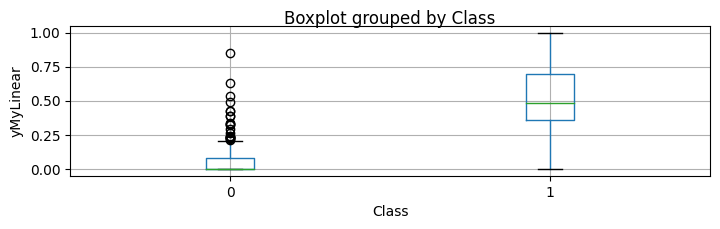

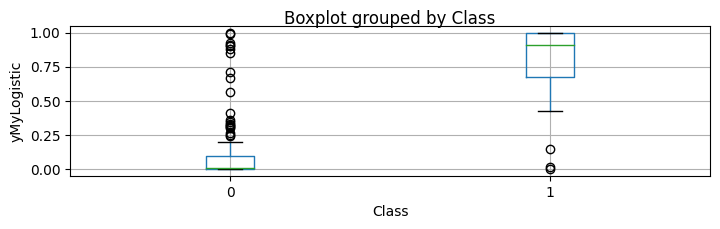

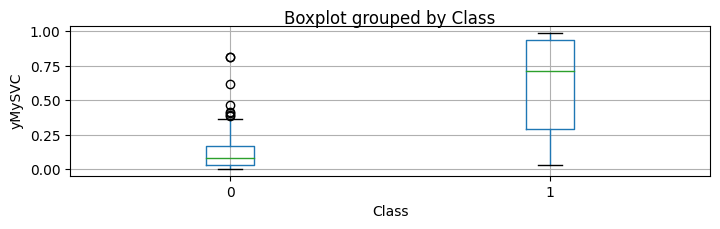

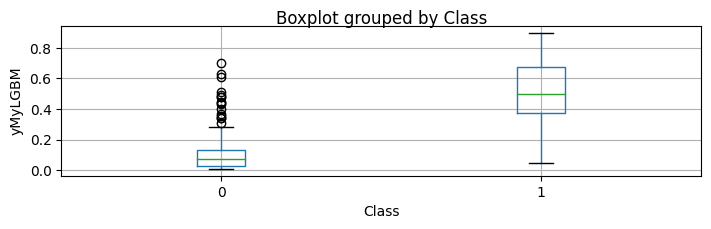

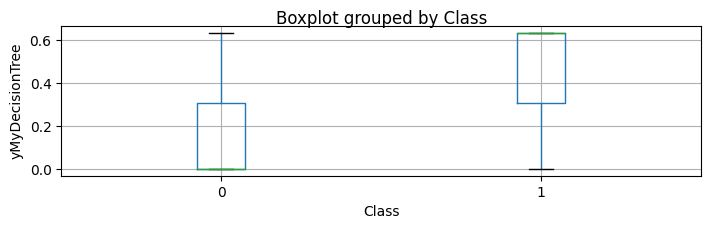

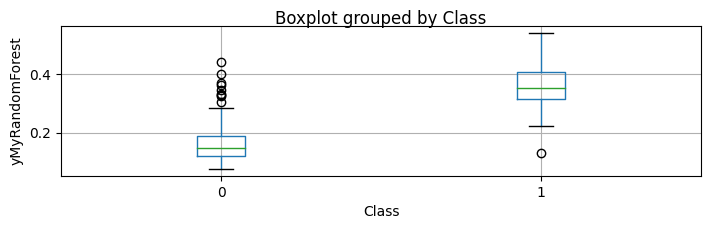

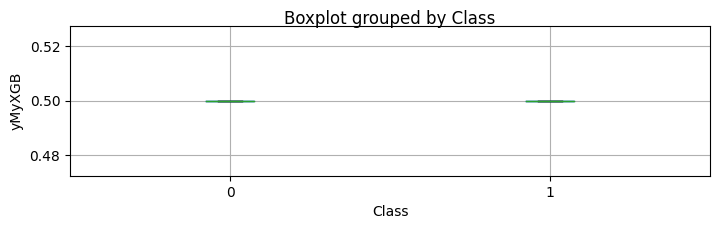

In [68]:
#working with some UPDRS-towards data
def printTargetModelCase():
    global u
    # for u in targetVars:
    for yModel in yModels:
        formalism = type(yModels[yModel]).__name__
        print('***********', formalism, end=': ')
        if formalism=='MyXGBClassifier':
            g=2
            # print(y_pred)
        # myTarget = targetVars[0]
        some_data = x_t[3]#[: 50]
        some_labels = y_t[3][u].to_list()#[: 50]
        # display(some_labels)
        some_data_prepared = pd.DataFrame(fullPipeline.transform(some_data), 
                                          columns=x_tTransf[0].columns)
        # display(some_data_prepared)
        y_pred = getPrediction(yModels[yModel], some_data_prepared) #[y_p for y_p in yModels[yModel].predict(some_data_prepared)]
        # y_pred = getPrediction(u, y_Pred) #np.round(np.expm1(y_pred))

        #y_pred = sum(np.array(y_pred).tolist(), [])
        some_cases = pd.DataFrame({u: some_labels,#[myTarget], 
                                yModel: y_pred.to_list()})
        #                           index = some_labels.index)
        # display(some_cases)
        myPlot = some_cases.boxplot(column=some_cases.columns[1],
                                    figsize=(8,2),
                                    vert=True, 
                                    by=some_cases.columns[0]);
            # some_cases.plot(x=some_cases.columns[1], 
            #                      y=some_cases.columns[0], 
            #                      style='o', 
            #                      figsize=(8,2));
        myPlot.set_ylabel(some_cases.columns[1])
        myPlot.set_xlabel(some_cases.columns[0])
        myPlot.set_title('')
        logLoss = LOG_LOSS(some_cases[u], some_cases[yModel])#some_cases.corr().iloc[0,1]
        print('logLoss=', logLoss)
        # if np.isnan(corr):
        #     print('very small std: ', pd.Series(y_pred).std())
        
        # display(some_cases.head())
        # residuals = some_cases[some_cases.columns[0]] - some_cases[some_cases.columns[1]]
        # print('residuals.describe() \n', residuals.describe())
        # residuals.hist(bins = 5);    
printTargetModelCase()

In [69]:
#evaluation measures for the log-UPDRS models
def getFormalismDictionary(models, formalismNm):
    # dic = []
    # for u in targetVars:
    for yModel in models:
        if yModel == formalismNm:
            return(models[yModel])
# for u in targetVars:
count = 0
for yModel in yModels:
    yModel_ = getFormalismDictionary(yModels, yModel)
    eModel_ = getFormalismDictionary(e_yModels, yModel)
    count +=1
    printResults = True if count == len(yModels) else False
    computePerformanceMeasures(yModel = yModel_, phase = 0, 
                            x_t = x_tTransf, #x_v = x_vTransf, 
                            y_t = y_t, #y_v = y_v, 
                            eModel=eModel_, printResults=printResults)

 *********** Best models via SMAPE in the validation set *********** 


,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyLogistic,0.108,0.55,0.442


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
1,yMyLogistic,0.108,0.550,0.442
3,yMyLGBM,0.273,0.655,0.382
2,yMySVC,0.404,0.685,0.281
6,yMyXGB,0.693,0.693,0.000
5,yMyRandomForest,0.777,0.910,0.133
4,yMyDecisionTree,0.594,2.544,1.950
0,yMyLinear,0.508,2.571,2.063


In [70]:
#printPredictorsCorrelation
#see https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sns
sns.set_theme(style="ticks")
def printPredictorsCorrelation(predDfs, modelsNms = None):
    for u in targetVars:
        # print('*************** ***************')
        # display('y_t', y_t)
        # display('df_t', predDfs['df_t'])
        # display('y_v', y_v)
        # display('df_v', predDfs['df_v'])
        # nDecs = 5
        # corr_t = round(predDfs['df_t'].corr(), nDecs)
        # corr_v = round(predDfs['df_v'].corr(), nDecs)
        # corr_v_t = round(corr_v/corr_t, nDecs)
        # display('df_t corr:', corr_t)
        # display('df_v corr:',  corr_v)
        # display('df_v corr/df_t corr:',  corr_v_t)
        auxDf = predDfs[0].copy()
        auxDf['phase'] = [u+'(train)']*len(auxDf)
        for i in [1, 3]:#nDataSubsets):
            auxDf_v = predDfs[i].copy()
            auxDf_v['phase'] = [u+'(validation '+str(i)+')']*len(auxDf_v)
            auxDf = pd.concat([auxDf, auxDf_v]) 
        if modelsNms is not None:
             auxDf = auxDf[modelsNms]
        sns.pairplot(auxDf, hue='phase', #kind="kde",# diag_kind='hist',  
                    #  markers=["o", "D"], 
                      height=2.5, corner=True)        
if isInKaggle:# or not isInKaggle:
    printPredictorsCorrelation(predDfs=e_yPredictions)#e_yPredictions)#yPredictions)

#### Studying features importance

In [71]:
isToRunInitialModels

{'MyLinearRegressor': True,
 'MyLogisticRegression': True,
 'MySVC': True,
 'MyLGBMClassifier': True,
 'MyXGBClassifier': True,
 'MyDecisionTreeClassifier': True,
 'MyRandomForestClassifier': True,
 'MyMLPClassifier': False,
 'MyTfMLPClassifier': False,
 'MyTfRNNClassifier': False}

In [72]:
def getFeaturesImportance(modelObjs, nFeatures):
    importantFeatures = {}
    # for u in targetVars:
    columns = x_tTransf[0].columns
    # if isWithPCA:
    #     columns = x_tTransf[0].columns
    features_importance = None
    signals = None
    if type(modelObjs).__name__ == 'MyLinearRegressor':
        try: modelObj = modelObjs.model
        except: modelObj = modelObjs
        coefs = modelObj.coef_[0]
        features_importance = abs(coefs)
        nPredictors = len(features_importance)
        signals = ['(~)']*nPredictors
        for i in range(nPredictors):
            if coefs[i] < 0: 
                signals[i] = '(-)'
            elif coefs[i] > 0:
                signals[i] = '(+)'
            else:
                signals[i] = '(without)'
    else:
        features_importance = modelObj.feature_importances_ 
        nPredictors = len(features_importance)
        signals = ['(+)']*nPredictors
    fi = pd.DataFrame(data={'importance': features_importance, 'signal': signals},
            index=columns)
    fi = fi.sort_values('importance', ascending=False)#.plot(kind='barh', title='Feature Importance')
    if nFeatures is None:
        nFeatures = nPredictors
    print('|| importantFeatures:  \n', fi.head(nFeatures))
    importantFeatures = []
    for case in fi.index[:nFeatures]:
        importantFeatures.append(case)
    # print(res)
    importantFeatures = list(dict.fromkeys(importantFeatures))
    # print('|| importantFeatures: ', u, importantFeatures)    
    return importantFeatures

yLinearImportantFeatures = None
if isToRunInitialModels['MyLinearRegressor']:
    yLinearImportantFeatures = getFeaturesImportance(modelObjs = getFormalismDictionary(yModels, 'yMyLinear'), 
                                                    nFeatures = None)


|| importantFeatures:  
     importance signal
EJ    0.245714    (-)
DU    0.151095    (+)
FD    0.118796    (+)
CH    0.112734    (-)
FI    0.101056    (-)
AB    0.100397    (+)
DI    0.080486    (+)
BQ    0.069323    (+)
EP    0.069039    (-)
DN    0.068217    (-)
DY    0.067625    (+)
CW    0.061188    (-)
FL    0.061078    (+)
AX    0.060082    (-)
EE    0.054560    (-)
AZ    0.052913    (+)
CD    0.051280    (+)
GB    0.050418    (+)
EB    0.046837    (+)
DA    0.045658    (-)
BC    0.045520    (+)
AR    0.035721    (-)
DH    0.035675    (-)
GH    0.035433    (+)
CU    0.035218    (-)
GL    0.033890    (-)
GE    0.033592    (-)
FR    0.032036    (+)
CB    0.031658    (-)
FC    0.029469    (-)
FE    0.028789    (+)
CL    0.028186    (+)
EH    0.027530    (-)
FS    0.024726    (-)
CR    0.024130    (+)
AH    0.024009    (+)
DV    0.022048    (+)
GI    0.021140    (-)
EG    0.018990    (+)
EL    0.018738    (+)
BZ    0.018207    (+)
AM    0.017763    (+)
BR    0.016081    (-)
AY    0

In [73]:
yLinearImportantFeatures

['EJ',
 'DU',
 'FD',
 'CH',
 'FI',
 'AB',
 'DI',
 'BQ',
 'EP',
 'DN',
 'DY',
 'CW',
 'FL',
 'AX',
 'EE',
 'AZ',
 'CD',
 'GB',
 'EB',
 'DA',
 'BC',
 'AR',
 'DH',
 'GH',
 'CU',
 'GL',
 'GE',
 'FR',
 'CB',
 'FC',
 'FE',
 'CL',
 'EH',
 'FS',
 'CR',
 'AH',
 'DV',
 'GI',
 'EG',
 'EL',
 'BZ',
 'AM',
 'BR',
 'AY',
 'AF',
 'EU',
 'DL',
 'CS',
 'BN',
 'GF',
 'CF',
 'CC',
 'BP',
 'BD',
 'DF',
 'DE']

## Error (Boosting) models

In [74]:
e_yPredictions

{0:      yMyLinear  yMyLogistic    yMySVC   yMyLGBM  yMyDecisionTree   
 1     0.000000    -0.000029 -0.024498 -0.118632         0.000000  \
 11    0.000000    -0.002886 -0.098927 -0.068095        -0.305556   
 13    0.301340     0.061189  0.084033  0.171858         0.694444   
 14    0.000000    -0.000315 -0.075178 -0.151792         0.000000   
 16    0.000000    -0.017276 -0.090807 -0.026984         0.000000   
 ..         ...          ...       ...       ...              ...   
 581   0.000000    -0.078606 -0.105986 -0.393570        -0.305556   
 597   0.000000    -0.000672 -0.015099 -0.011506         0.000000   
 608   0.231405     0.162125  0.040419  0.497003         0.363636   
 609   0.000000    -0.008105 -0.041366 -0.097864         0.000000   
 616   0.000000    -0.001070 -0.047146 -0.037034         0.000000   
 
      yMyRandomForest  yMyXGB  
 1          -0.129254    -0.5  
 11         -0.295384    -0.5  
 13          0.618236     0.5  
 14         -0.223691    -0.5  
 16    

In [75]:
e_yPredictions[0].columns

Index(['yMyLinear', 'yMyLogistic', 'yMySVC', 'yMyLGBM', 'yMyDecisionTree',
       'yMyRandomForest', 'yMyXGB'],
      dtype='object')

In [76]:
#computing the train and validation residuals
# for u in targetVars:
e_t = {}; e_v = {}
for yModel in yModels:
    e_t[yModel] = e_yPredictions[1][yModel]#getModelResiduals(u, 'df_t', yModel) #yModels[yModel], x_tTransf, y_t)    
    e_v[yModel] = e_yPredictions[3][yModel]#getModelResiduals(u, 'df_v', yModel) #yModels[yModel], x_vTransf, y_v)    


In [77]:
# getErrorModels(...): function for performing the residuals-based boosting
# import tensorflow as tf
# import copy


def getErrorModels(modelObjs, parsDists=None, parsGrid=None, nFeatures=None, toPrintFeaturesImportance=True):
    eModels = {}
    importantFeatures = {}  # yModelsDic={}
# for u in targetVars:
    formalism = type(modelObjs).__name__
    print('****** Error model.fit', formalism, u, ' ******')
    # eModels = {}
    isTfFormalism = True if (
        formalism == 'MyTfMLPRegressor' or formalism == 'MyTfRNNRegressor') else False
    # isMyBoostFormalism = True if (formalism == 'MyXGBRegressor' or formalism == 'MyLGBMRegressor') else False
    for yModel in e_t:
        # print('****** yModel', yModel, u, ' ******')
        # print(e_t[yModel])
        model = modelObjs
        modelName = getModelName(yModel, formalism)  # , u)
        x = x_tTransf[1]
        y = e_t[yModel]
        if parsGrid is not None:
            model = keras.wrappers.scikit_learn.KerasRegressor(
                model) if isTfFormalism else model
            eModels[yModel] = getOptimalModel(
                model, parsGrid, x, y, False, method='GridSearchCV', modelName=modelName)
        elif parsDists is not None:
            model = keras.wrappers.scikit_learn.KerasRegressor(
                model) if isTfFormalism else model
            eModels[yModel] = getOptimalModel(
                model, parsDists, x, y, False, method='BayesSearchCV', modelName=modelName)
        else:
            # if isTfFormalism or isMyBoostFormalism:
            model.fit(x, y, modelName)
            # else:
            #     model.fit(x, y)
            eModels[yModel] = model
        # importantFeatures = {}
        if toPrintFeaturesImportance:
            importantFeatures[yModel] = getFeaturesImportance(
                modelObjs=eModels[yModel], nFeatures=nFeatures)
    nCases = len(e_t)  # [targetVars[0]])
    i = 0
    for yModel in e_t:  # [targetVars[0]]:
        i += 1
        yModelDic = getFormalismDictionary(yModels, yModel)
        e_yModelDic = getFormalismDictionary(eModels, yModel)
        # print(yModelDic)
        printResults = True if i == nCases else False
        computePerformanceMeasures(yModel=yModelDic, phase=1, x_t=x_tTransf,
                                   y_t=y_t, eModel=e_yModelDic, printResults=printResults)
    return {'eModels': eModels, 'importantFeatures': importantFeatures}

In [78]:
#computeErrorModels for executing the getErrorModels for the desired formalism
def computeErrorModels(modelObj, parsDists, grids):
        eModelsObjs = {}
        # global u
        modelObj_ = modelObj if type(modelObj).__name__ != 'dict' else modelObj
        formalism = type(modelObj_).__name__
        eModelsObjs = errorModelsObjs[formalism] if (parsDists is None and grids is None) else modelObj_
        getErrorModels(eModelsObjs, parsDists, grids, nFeatures=50, toPrintFeaturesImportance=False)

#### Residuals-towards Decision Tree

In [79]:
#modelling and evaluating
# from sklearn.tree import MyDecisionTreeRegressor
if isToRunErrorModels['MyDecisionTreeRegressor']:
    grids = {}; parsDists = {}; 
    # for u in targetVars:
    parsDists = None if not isWithOptimization else {
        'splitter': ["best", "random"],  # categorical parameter
        'max_depth': (1, 10),  # integer valued parameter
        'min_samples_split': (2, 500),
        'min_samples_leaf': (1, 50),
        'max_features': (1, x_tTransf[0].shape[1]),
        # log-uniform: understand as search over p = exp(x) by varying x
        'ccp_alpha': (1e-10, 1e+1, 'log-uniform')
    }
    grids = None if not isWithOptimization else { 
                'min_samples_leaf': [2, 5, 50, 80, 100],
                'min_samples_split': [2, 50, 500, 1000],
    }
    computeErrorModels(MyDecisionTreeRegressor(), parsDists, grids)

****** Error model.fit MyDecisionTreeRegressor Class  ******
==**** load_model yMyLinear_eMyDecisionTree ****==
>>> elapsed time: 0.0060002803802490234 seconds!
==**** load_model yMyLogistic_eMyDecisionTree ****==
>>> elapsed time: 0.0063321590423583984 seconds!
==**** load_model yMySVC_eMyDecisionTree ****==
>>> elapsed time: 0.005587100982666016 seconds!
==**** load_model yMyLGBM_eMyDecisionTree ****==
>>> elapsed time: 0.004975795745849609 seconds!
==**** load_model yMyDecisionTree_eMyDecisionTree ****==
>>> elapsed time: 0.0039904117584228516 seconds!
==**** load_model yMyRandomForest_eMyDecisionTree ****==
>>> elapsed time: 0.005005598068237305 seconds!
==**** load_model yMyXGB_eMyDecisionTree ****==
>>> elapsed time: 0.006002187728881836 seconds!
 *********** Best models via SMAPE in the validation set *********** 


,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyLogistic,0.108,0.55,0.442


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
1,yMyLogistic,0.108,0.550,0.442
3,yMyLGBM,0.273,0.655,0.382
2,yMySVC,0.404,0.685,0.281
6,yMyXGB,0.693,0.693,0.000
13,yMyXGB_eMyDecisionTree,0.884,0.746,-0.138
5,yMyRandomForest,0.777,0.910,0.133
8,yMyLogistic_eMyDecisionTree,0.882,1.399,0.517
9,yMySVC_eMyDecisionTree,1.528,1.452,-0.076
7,yMyLinear_eMyDecisionTree,1.690,2.533,0.843
4,yMyDecisionTree,0.594,2.544,1.950


#### Residuals-towards Light GBM Regression

In [82]:
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
# !pip install lightgbm
# import lightgbm as lgb
if isToRunErrorModels['MyLGBMRegressor']:
    gridLg = {}; parsDists = {}
    for u in targetVars:
        parsDists = {'num_leaves': (2, 300),
            'max_depth': (1, 50),
            # 'learning_rate':(.1, 1, 'uniform'),
            'n_estimators': (2, 300)} if isWithOptimization else None
        gridLg = None if not isWithOptimization else {'max_depth': [-1, 1, 10, 50],
            # 'learning_rate':(.1, 2, 'uniform'),
            'n_estimators': [2, 5, 50, 100]}
    computeErrorModels(MyLGBMRegressor(), parsDists, gridLg), #parsDists, 
                                        #    n_estimators=5, max_depth=10),  # )

****** Error model.fit MyLGBMRegressor Class  ******


==**** load_model yMyLinear_eMyLGBM ****==
>>> elapsed time: 42.61136317253113 seconds!
==**** load_model yMyLogistic_eMyLGBM ****==
>>> elapsed time: 43.05819773674011 seconds!
==**** load_model yMySVC_eMyLGBM ****==
>>> elapsed time: 68.36393570899963 seconds!
==**** load_model yMyLGBM_eMyLGBM ****==
>>> elapsed time: 102.81850123405457 seconds!
==**** load_model yMyDecisionTree_eMyLGBM ****==
>>> elapsed time: 8.969510793685913 seconds!
==**** load_model yMyRandomForest_eMyLGBM ****==
>>> elapsed time: 8.173982858657837 seconds!
==**** fit yMyXGB_eMyLGBM ****==


AttributeError: 'Booster' object has no attribute 'fit'

: 

#### Residuals-towards Random Forest

In [ ]:
# from sklearn.ensemble import MyRandomForestRegressor 
if isToRunErrorModels['MyRandomForestRegressor']:
    gridForest = {}; parsDists = {}
    # for u in targetVars:
    parsDists = {
                    'max_depth': (1, 200),  # integer valued parameter
                'min_samples_split': (.01, 1, 'uniform'),
                'min_samples_leaf': (1, 60),
                'n_estimators': (2, 600),
                    'max_features': (.1, .9, 'uniform'),
                # log-uniform: understand as search over p = exp(x) by varying x
                'ccp_alpha': (1e-10, 1e+1, 'log-uniform')
                } if isWithOptimization else None
    gridForest = None if not isWithOptimization else {'n_estimators':[10, 100, 200],
                'min_samples_split': [2, 50, 200, 500]}
    computeErrorModels(MyRandomForestRegressor(), parsDists, gridForest)# #parsDists, 
                                                #    min_samples_split = 100, n_estimators = 100), 

****** Error model.fit MyRandomForestRegressor Class  ******
==**** load_model yMyLinear_eMyRandomForest ****==
>>> elapsed time: 0.05060076713562012 seconds!
==**** load_model yMyLogistic_eMyRandomForest ****==
>>> elapsed time: 0.0388033390045166 seconds!
==**** load_model yMySVC_eMyRandomForest ****==
>>> elapsed time: 0.03935956954956055 seconds!
==**** load_model yMyLGBM_eMyRandomForest ****==
>>> elapsed time: 0.04076361656188965 seconds!
==**** load_model yMyDecisionTree_eMyRandomForest ****==
>>> elapsed time: 0.04217338562011719 seconds!
==**** load_model yMyRandomForest_eMyRandomForest ****==
>>> elapsed time: 0.04135298728942871 seconds!
==**** load_model yMyXGB_eMyRandomForest ****==
>>> elapsed time: 0.03870725631713867 seconds!
==**** load_model yMyMLP_eMyRandomForest ****==
>>> elapsed time: 0.03980708122253418 seconds!
==**** load_model yMyTfMLP_eMyRandomForest ****==
>>> elapsed time: 0.0405881404876709 seconds!
==**** load_model yMyTfRNN_eMyRandomForest ****==
>>> ela

,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyLogistic,0.108,0.55,0.442


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
38,yMyTfMLP_eMyRandomForest,0.300,0.438,0.138
21,yMyLogistic_eMyLGBM,0.207,0.455,0.248
18,yMyTfMLP_eMyDecisionTree,0.651,0.459,-0.192
28,yMyTfMLP_eMyLGBM,0.437,0.485,0.048
22,yMySVC_eMyLGBM,0.353,0.519,0.166
37,yMyMLP_eMyRandomForest,0.424,0.538,0.114
1,yMyLogistic,0.108,0.550,0.442
39,yMyTfRNN_eMyRandomForest,0.465,0.592,0.127
8,yMyTfMLP,0.571,0.649,0.078
3,yMyLGBM,0.273,0.655,0.382


#### Residuals-towards XGBoost Regression

In [ ]:
# !pip install xgboost
# import xgboost as xg
if isToRunErrorModels['MyXGBRegressor']:
    gridXg = {}; parsDists = {}
    # for u in targetVars:    
    parsDists = {#'splitter': ["best", "random"],  # categorical parameter
            # 'max_depth': (1, 50),  # integer valued parameter
            # 'n_estimators': (2, 100),
            'eta': (.01, 1, 'log-uniform'), 
            'gamma': (0, 1, 'uniform'),
            } if isWithOptimization else None
    gridXg = None if not isWithOptimization else {
        'max_depth': [1, 5, 6, 10],  
        #   'n_estimators': (3, 10, 20)
        'eta': [.1, 0.3, .6],
        'gamma': [0, 1, 2],
    }
    computeErrorModels(MyXGBRegressor(), parsDists, gridXg)#, #parsDists, #None, 
                                # n_estimators = 3, max_depth = 5), 

****** Error model.fit MyXGBRegressor Class  ******
==**** load_model yMyLinear_eMyXGB ****==
>>> elapsed time: 0.0029916763305664062 seconds!
==**** load_model yMyLogistic_eMyXGB ****==
>>> elapsed time: 0.002002239227294922 seconds!
==**** load_model yMySVC_eMyXGB ****==
>>> elapsed time: 0.0009982585906982422 seconds!
==**** load_model yMyLGBM_eMyXGB ****==
>>> elapsed time: 0.0 seconds!
==**** load_model yMyDecisionTree_eMyXGB ****==
>>> elapsed time: 0.0010116100311279297 seconds!
==**** load_model yMyRandomForest_eMyXGB ****==
>>> elapsed time: 0.0009865760803222656 seconds!
==**** load_model yMyXGB_eMyXGB ****==
>>> elapsed time: 0.001001119613647461 seconds!
==**** load_model yMyMLP_eMyXGB ****==
>>> elapsed time: 0.0009999275207519531 seconds!
==**** load_model yMyTfMLP_eMyXGB ****==
>>> elapsed time: 0.0 seconds!
==**** load_model yMyTfRNN_eMyXGB ****==
>>> elapsed time: 0.001013040542602539 seconds!
 *********** Best models via SMAPE in the validation set *********** 


,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
48,yMyTfMLP_eMyXGB,0.036,0.299,0.263
45,yMyRandomForest_eMyXGB,0.040,0.368,0.328
47,yMyMLP_eMyXGB,0.100,0.373,0.273
49,yMyTfRNN_eMyXGB,0.076,0.398,0.322
38,yMyTfMLP_eMyRandomForest,0.300,0.438,0.138
21,yMyLogistic_eMyLGBM,0.207,0.455,0.248
18,yMyTfMLP_eMyDecisionTree,0.651,0.459,-0.192
28,yMyTfMLP_eMyLGBM,0.437,0.485,0.048
22,yMySVC_eMyLGBM,0.353,0.519,0.166
37,yMyMLP_eMyRandomForest,0.424,0.538,0.114


In [ ]:
import IPython
IPython.__version__

'8.13.2'

#### Residuals-towards Support Vector Regression - SVR

In [ ]:
# from sklearn.svm import SVC
if isToRunErrorModels['MySVR']:
    gridSVR = {}; parsDists = {}
    # for u in targetVars:
    parsDists = parsDistsSVC if isWithOptimization else None
    gridSVR = None if not isWithOptimization else {'kernel': ['poly', 'rbf', 'sigmoid'],#'linear', 
        'C':[.001, .05, 1, 1.5], 
        'epsilon': [.01, .1, .2]}
    computeErrorModels(MySVR(), parsDists, gridSVR)#parsDists, SVC(, max_iter=2000)


****** Error model.fit MySVR Class  ******
==**** load_model yMyLinear_eMySVR ****==
>>> elapsed time: 0.002656221389770508 seconds!
==**** load_model yMyLogistic_eMySVR ****==
>>> elapsed time: 0.002004861831665039 seconds!
==**** load_model yMySVC_eMySVR ****==
>>> elapsed time: 0.002008199691772461 seconds!
==**** load_model yMyLGBM_eMySVR ****==
>>> elapsed time: 0.002321958541870117 seconds!
==**** load_model yMyDecisionTree_eMySVR ****==
>>> elapsed time: 0.0028040409088134766 seconds!
==**** load_model yMyRandomForest_eMySVR ****==
>>> elapsed time: 0.0019991397857666016 seconds!
==**** load_model yMyXGB_eMySVR ****==
>>> elapsed time: 0.0020711421966552734 seconds!
==**** load_model yMyMLP_eMySVR ****==
>>> elapsed time: 0.0025565624237060547 seconds!
==**** load_model yMyTfMLP_eMySVR ****==
>>> elapsed time: 0.0015811920166015625 seconds!
==**** load_model yMyTfRNN_eMySVR ****==
>>> elapsed time: 0.0026209354400634766 seconds!
 *********** Best models via SMAPE in the validati

,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
48,yMyTfMLP_eMyXGB,0.036,0.299,0.263
53,yMyLGBM_eMySVR,0.018,0.363,0.345
45,yMyRandomForest_eMyXGB,0.040,0.368,0.328
47,yMyMLP_eMyXGB,0.100,0.373,0.273
54,yMyDecisionTree_eMySVR,0.027,0.379,0.352
49,yMyTfRNN_eMyXGB,0.076,0.398,0.322
38,yMyTfMLP_eMyRandomForest,0.300,0.438,0.138
55,yMyRandomForest_eMySVR,0.018,0.441,0.423
21,yMyLogistic_eMyLGBM,0.207,0.455,0.248
18,yMyTfMLP_eMyDecisionTree,0.651,0.459,-0.192


#### Residuals-towards Artificial Neural Network - ANN

In [ ]:
# #https://towardsdatascience.com/deep-neural-multilayer-perceptron-mlp-with-scikit-learn-2698e77155e

if isToRunErrorModels['MyMLPRegressor']:
    gridMLP = {}; parsDists = {}
    # for u in targetVars:
    parsDists = None if not isWithOptimization else {'activation': ['relu', 'identity', 'logistic', 'tanh'],  # categorical parameter,
            'learning_rate' : ['constant', 'invscaling', 'adaptive'],
            #  'hidden_layer_sizes':[(2,2), (5,2), (5,3,2)],
            'max_iter':(100, 500), 
            'alpha': (1e-5, 2e-1, 'log-uniform'),  # integer valued parameter
            'tol': (1e-4, 1e-1, 'log-uniform'),
            }
    gridMLP = None if not isWithOptimization else {'activation': ['relu', 'identity', 'logistic', 'tanh'],  # categorical parameter,
        # 'learning_rate' : ['constant', 'invscaling', 'adaptive'],
        #  'hidden_layer_sizes':[(2,2), (5,2), (5,3,2)],
        # 'max_iter':(100, 500), 
        # 'alpha': (1e-5, 2e-1, 'log-uniform')  # integer valued parameter
        # 'tol': (1e-4, 1e-1, 'log-uniform')
        # hidden_layer_sizes = [(1), (10), (50), (10, 10)],
    }
    computeErrorModels(MyMLPRegressor(), parsDists, gridMLP) #parsDists, 
                            # hidden_layer_sizes=(10, 5, 2), activation="relu", max_iter=2000), 


****** Error model.fit MyMLPRegressor Class  ******
==**** load_model yMyLinear_eMyMLP ****==
>>> elapsed time: 0.007639169692993164 seconds!
==**** load_model yMyLogistic_eMyMLP ****==
>>> elapsed time: 0.00716090202331543 seconds!
==**** load_model yMySVC_eMyMLP ****==
>>> elapsed time: 0.0060040950775146484 seconds!
==**** load_model yMyLGBM_eMyMLP ****==
>>> elapsed time: 0.005000114440917969 seconds!
==**** load_model yMyDecisionTree_eMyMLP ****==
>>> elapsed time: 0.006749629974365234 seconds!
==**** load_model yMyRandomForest_eMyMLP ****==
>>> elapsed time: 0.0069980621337890625 seconds!
==**** load_model yMyXGB_eMyMLP ****==
>>> elapsed time: 0.0050241947174072266 seconds!
==**** load_model yMyMLP_eMyMLP ****==
>>> elapsed time: 0.007309675216674805 seconds!
==**** load_model yMyTfMLP_eMyMLP ****==
>>> elapsed time: 0.005875110626220703 seconds!
==**** load_model yMyTfRNN_eMyMLP ****==
>>> elapsed time: 0.007206916809082031 seconds!
 *********** Best models via SMAPE in the val

,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
48,yMyTfMLP_eMyXGB,0.036,0.299,0.263
53,yMyLGBM_eMySVR,0.018,0.363,0.345
45,yMyRandomForest_eMyXGB,0.040,0.368,0.328
47,yMyMLP_eMyXGB,0.100,0.373,0.273
54,yMyDecisionTree_eMySVR,0.027,0.379,0.352
...,...,...,...,...
60,yMyLinear_eMyMLP,0.089,2.472,2.383
4,yMyDecisionTree,0.594,2.544,1.950
0,yMyLinear,0.508,2.571,2.063
61,yMyLogistic_eMyMLP,0.043,3.359,3.316


##### Keras-TensorFlow ANN

In [ ]:
# # #https://www.tensorflow.org/install
# # # Requires the latest pip
# # # !-m pip install --upgrade pip
# # # Current stable release for CPU and GPU
# # # !pip install tensorflow
# # #Testing if tensorflow is installed
# # import tensorflow as tf 
# from tensorflow import keras 
# # print('tf.__version__: ', tf.__version__)
# # print('__version__: ', keras.__version__)
# # print('x_train.shape: ', x_train.shape)

In [ ]:
if isToRunErrorModels['MyTfMLPRegressor']:
    # early_stopping_cb = keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=5, restore_best_weights=True)
    gridTfAnn = {}; parsDists = {}; 
    # for u in targetVars:
    parsDists = None if not isWithOptimization else {#'nHiddenLayers': (0, 15),
                #'hidden_layer_sizes': (1, 20),
                'learningRate': (1e-3, .2, 'uniform'),
                'inpute_layer_dropout_rate': (0, .4, 'uniform')
                }
    gridTfAnn = None if not isWithOptimization else {'inpute_layer_dropout_rate': [0, .1, .4],
            #  'nHiddenLayers': [0, 1, 10, 20],
            #  'nNeurons': [1, 2, 20], 
                'learningRate': [1e-3, .01, .2],
                }
    # modelObj = keras.wrappers.scikit_learn.KerasRegressor(MyTfMLPRegressor)
    computeErrorModels(MyTfMLPRegressor(u, 'errorModel'), parsDists, gridTfAnn)


****** Error model.fit MyTfMLPRegressor Class  ******
==**** load_model yMyLinear_eMyTfMLP ****==
>>> elapsed time: 0.1311202049255371 seconds!
==**** load_model yMyLogistic_eMyTfMLP ****==
>>> elapsed time: 0.1304183006286621 seconds!
==**** load_model yMySVC_eMyTfMLP ****==
>>> elapsed time: 0.1334228515625 seconds!
==**** load_model yMyLGBM_eMyTfMLP ****==
>>> elapsed time: 0.1309833526611328 seconds!
==**** load_model yMyDecisionTree_eMyTfMLP ****==
>>> elapsed time: 0.13383698463439941 seconds!
==**** load_model yMyRandomForest_eMyTfMLP ****==
>>> elapsed time: 0.13096833229064941 seconds!
==**** load_model yMyXGB_eMyTfMLP ****==
>>> elapsed time: 0.1298825740814209 seconds!
==**** load_model yMyMLP_eMyTfMLP ****==
>>> elapsed time: 0.1286022663116455 seconds!
==**** load_model yMyTfMLP_eMyTfMLP ****==
>>> elapsed time: 0.12640166282653809 seconds!
==**** load_model yMyTfRNN_eMyTfMLP ****==
>>> elapsed time: 0.13271284103393555 seconds!
 *********** Best models via SMAPE in the va

,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
48,yMyTfMLP_eMyXGB,0.036,0.299,0.263
53,yMyLGBM_eMySVR,0.018,0.363,0.345
45,yMyRandomForest_eMyXGB,0.040,0.368,0.328
47,yMyMLP_eMyXGB,0.100,0.373,0.273
54,yMyDecisionTree_eMySVR,0.027,0.379,0.352
...,...,...,...,...
70,yMyLinear_eMyTfMLP,1.244,2.778,1.534
72,yMySVC_eMyTfMLP,1.101,2.778,1.677
61,yMyLogistic_eMyMLP,0.043,3.359,3.316
77,yMyMLP_eMyTfMLP,2.628,3.434,0.806


In [ ]:
if isToRunErrorModels['MyTfRNNRegressor']:
    # early_stopping_cb = keras.callbacks.EarlyStopping(
    #     monitor='val_loss', patience=5, restore_best_weights=True)
    grid = {}; parsDists = {}; 
    # for u in targetVars:
    parsDists = None if not isWithOptimization else {#'nHiddenLayers': (0, 15),
                #'hidden_layer_sizes': (1, 20),
                'learningRate': (1e-3, .2, 'uniform'),
                'inpute_layer_dropout_rate': (0, .4, 'uniform')
                }
    grid = None if not isWithOptimization else {
        'inpute_layer_dropout_rate': [0, .1, .4],
            #  'nHiddenLayers': [0, 1, 10, 20],
            #  'nNeurons': [1, 2, 20], 
                'learningRate': [1e-3, .01, .2],
                }
    # modelObj = keras.wrappers.scikit_learn.KerasRegressor(MyTfMLPRegressor)
    computeErrorModels(MyTfRNNRegressor(u, 'errorModel'), parsDists, grid)


****** Error model.fit MyTfRNNRegressor Class  ******
==**** load_model yMyLinear_eMyTfRNN ****==
>>> elapsed time: 2.257549285888672 seconds!
==**** load_model yMyLogistic_eMyTfRNN ****==
>>> elapsed time: 2.2460310459136963 seconds!
==**** load_model yMySVC_eMyTfRNN ****==
>>> elapsed time: 2.3277080059051514 seconds!
==**** load_model yMyLGBM_eMyTfRNN ****==
>>> elapsed time: 2.143719434738159 seconds!
==**** load_model yMyDecisionTree_eMyTfRNN ****==
>>> elapsed time: 2.150620222091675 seconds!
==**** load_model yMyRandomForest_eMyTfRNN ****==
>>> elapsed time: 2.146812677383423 seconds!
==**** load_model yMyXGB_eMyTfRNN ****==
>>> elapsed time: 2.1738598346710205 seconds!
==**** load_model yMyMLP_eMyTfRNN ****==
>>> elapsed time: 2.5567033290863037 seconds!
==**** load_model yMyTfMLP_eMyTfRNN ****==
>>> elapsed time: 2.1195406913757324 seconds!
==**** load_model yMyTfRNN_eMyTfRNN ****==
>>> elapsed time: 2.102085590362549 seconds!
 *********** Best models via SMAPE in the validati

,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
48,yMyTfMLP_eMyXGB,0.036,0.299,0.263
53,yMyLGBM_eMySVR,0.018,0.363,0.345
45,yMyRandomForest_eMyXGB,0.040,0.368,0.328
47,yMyMLP_eMyXGB,0.100,0.373,0.273
54,yMyDecisionTree_eMySVR,0.027,0.379,0.352
...,...,...,...,...
80,yMyLinear_eMyTfRNN,1.150,2.782,1.632
61,yMyLogistic_eMyMLP,0.043,3.359,3.316
77,yMyMLP_eMyTfMLP,2.628,3.434,0.806
82,yMySVC_eMyTfRNN,1.071,3.678,2.607


## Combiners (Stacking)
https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html#sphx-glr-auto-examples-ensemble-plot-stack-predictors-py

#### Linear combiners

In [ ]:
yPredictions[1].columns

Index(['Class', 'yMyLinear', 'yMyLogistic', 'yMySVC', 'yMyLGBM',
       'yMyDecisionTree', 'yMyRandomForest', 'yMyXGB', 'yMyMLP', 'yMyTfMLP',
       'yMyTfRNN', 'yMyLinear_eMyDecisionTree', 'yMyLogistic_eMyDecisionTree',
       'yMySVC_eMyDecisionTree', 'yMyLGBM_eMyDecisionTree',
       'yMyDecisionTree_eMyDecisionTree', 'yMyRandomForest_eMyDecisionTree',
       'yMyXGB_eMyDecisionTree', 'yMyMLP_eMyDecisionTree',
       'yMyTfMLP_eMyDecisionTree', 'yMyTfRNN_eMyDecisionTree',
       'yMyLinear_eMyLGBM', 'yMyLogistic_eMyLGBM', 'yMySVC_eMyLGBM',
       'yMyLGBM_eMyLGBM', 'yMyDecisionTree_eMyLGBM', 'yMyRandomForest_eMyLGBM',
       'yMyXGB_eMyLGBM', 'yMyMLP_eMyLGBM', 'yMyTfMLP_eMyLGBM',
       'yMyTfRNN_eMyLGBM', 'yMyLinear_eMyRandomForest',
       'yMyLogistic_eMyRandomForest', 'yMySVC_eMyRandomForest',
       'yMyLGBM_eMyRandomForest', 'yMyDecisionTree_eMyRandomForest',
       'yMyRandomForest_eMyRandomForest', 'yMyXGB_eMyRandomForest',
       'yMyMLP_eMyRandomForest', 'yMyTfMLP_eMyRando

In [ ]:
def getSingleModelsNms(isToPrint = False):
    # ySingleModelsNms = {}
    # u = targetVars[0]
    # ySingleModelsNms = list(yPredictions[1].columns)
    # ySingleModelsNms.remove(u)
    modelsPerformance = pd.read_csv(PERFORMANCE_ROOT+'modelsPerformance.csv', sep='\t')
    modelsPerformance.sort_values(by=['logLoss_dif_vt', 'logLoss_v', 'logLoss_t'], 
                                  ascending=True, inplace=True)
    nModels = modelsPerformance.shape[0]
    index = np.min([nModels-1, 2])
    treshold = np.max([CombMVMaxLogLoss_dif_vt, modelsPerformance.logLoss_dif_vt[index]])
    ySingleModelsNms = modelsPerformance.model[modelsPerformance.logLoss_dif_vt <= treshold].to_list()
    if isToPrint:
        print('******* # original ySingleModelsNms:',  nModels+1)
        print('******* # elected ySingleModelsNms:',  len(ySingleModelsNms))
        print('******* elected ySingleModelsNms:',  ySingleModelsNms)
        display('****** all single models performance ******', modelsPerformance)
    return ySingleModelsNms

ySingleModelsNms = getSingleModelsNms(isToPrint=True)

******* # original ySingleModelsNms: 91
******* # elected ySingleModelsNms: 31
******* elected ySingleModelsNms: ['yMyMLP_eMyDecisionTree', 'yMyLGBM_eMyDecisionTree', 'yMyTfMLP_eMyDecisionTree', 'yMyTfRNN_eMyDecisionTree', 'yMyRandomForest_eMyDecisionTree', 'yMyTfRNN_eMyTfMLP', 'yMyTfRNN_eMyLGBM', 'yMyTfRNN', 'yMyMLP_eMyLGBM', 'yMyTfMLP_eMyLGBM', 'yMyRandomForest_eMyLGBM', 'yMyTfMLP', 'yMyRandomForest_eMyTfMLP', 'yMyMLP_eMyRandomForest', 'yMyTfMLP_eMyTfMLP', 'yMyTfRNN_eMyRandomForest', 'yMyRandomForest', 'yMyTfMLP_eMyRandomForest', 'yMyMLP', 'yMySVC_eMyLGBM', 'yMyTfMLP_eMyTfRNN', 'yMyTfRNN_eMyTfRNN', 'yMyRandomForest_eMyTfRNN', 'yMyLogistic_eMyLGBM', 'yMyTfMLP_eMyXGB', 'yMyMLP_eMyXGB', 'yMySVC', 'yMyDecisionTree_eMyDecisionTree', 'yMyDecisionTree_eMyMLP', 'yMyTfRNN_eMyXGB', 'yMyRandomForest_eMyXGB']


'****** all single models performance ******'

,model,logLoss_t,logLoss_v,logLoss_dif_vt
59,yMyMLP_eMyDecisionTree,2.754,1.615,-1.139
45,yMyLGBM_eMyDecisionTree,2.405,1.319,-1.086
11,yMyTfMLP_eMyDecisionTree,0.651,0.459,-0.192
26,yMyTfRNN_eMyDecisionTree,0.883,0.746,-0.137
54,yMyRandomForest_eMyDecisionTree,1.530,1.434,-0.096
...,...,...,...,...
71,yMyLinear_eMySVR,0.020,2.367,2.347
75,yMyLinear_eMyMLP,0.089,2.472,2.383
88,yMySVC_eMyTfRNN,1.071,3.678,2.607
86,yMyLogistic_eMyMLP,0.043,3.359,3.316


In [ ]:
def getSingleModelsPreds(x, targetVar, useLogScale = False):
    # u = targetVar
    ySingleModelsPreds = pd.DataFrame(index=x.index)
    for modelNm in ySingleModelsNms:
        modelsObjs = singleModelsObjs[modelNm]#+'_'+u]
        y_tPred = getPrediction(yModel = modelsObjs['yModel'], x = x, 
                                      eModel=modelsObjs['eModel'])
        ySingleModelsPreds[modelNm] = y_tPred# if useLogScale else getPrediction(targetVar = u, y_Predictions = y_tPred)
        # ySingleModelsPreds[modelNm] = y_tPred
    return ySingleModelsPreds
class CombRNN:
    def __init__(self):
        self.targetVar = None
        self.w = {}
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        ySingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        self.model = MyTfRNNRegressor(self.targetVar, 'combinerModel', 
                hidden_layer_sizes = [5, 3, 2],#[100, 50, 40, 30, 20, 10, 5, 3, 2] 
                hidden_layer_dropout_rates = [0], 
                learningRate = 1e-3, inpute_layer_dropout_rate = 0)  
        modelNm = getModelName(yModel='yComb'+type(self.model).__name__.replace('Regressor', ''), 
                               targetVar=self.targetVar)     
        self.model.fit(X = ySingleModelsPreds, y=y,modelName= modelNm) 
        return self
    def predict(self, X):
        ySingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_Predictions = self.model.predict(ySingleModelsPreds)
        # ret = getPrediction(targetVar = self.targetVar, y_Predictions = y_Predictions)
        return y_Predictions
class CombMV:
    def __init__(self):
        self.targetVar = None
        self.w = {}
        # self.ySingleModelsPreds = None
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        # if self.ySingleModelsPreds is None:
        ySingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        residuals = ySingleModelsPreds.sub(y.values, axis = 0).mul(-1) #y - Preds
        cov =  np.cov(m=residuals, rowvar=False)
        invCov = None
        try:
            invCov = np.linalg.inv(cov)
        except:
            print('******', self.targetVar, 'trouble with cMV (LinAlgError: Singular matrix)')
            invCov = np.linalg.pinv(cov)
            # print('np.dot(invCov, cov) \n', np.dot(invCov, cov))

        # display(invCov_t)
        # print('len(invCov_t):', len(invCov_t))
        total = invCov.sum()
        for i in range(len(invCov)):
            self.w[ySingleModelsNms[i]] = invCov[i].sum()/total
        print('*********** cMV weigths', self.targetVar, ':', self.w)
        # cMV_dic = 'cMV'
        # e_yModelDic = None
        return self
    def predict(self, X):
        ySingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_Predictions = ySingleModelsPreds.mul(self.w).sum(axis=1)
        # ret = getPrediction(targetVar = self.targetVar, y_Predictions = y_Predictions)
        return y_Predictions
class CombSA:
    def __init__(self):
        self.targetVar = None
        self.w = {}
        # self.ySingleModelsPreds = ySingleModelsPreds
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        return self
    def predict(self, X):
        ySingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_Predictions = ySingleModelsPreds.mean(axis=1)
        # ret = getPrediction(targetVar = self.targetVar, y_Predictions = y_Predictions)
        return y_Predictions
class CombMd:
    def __init__(self):
        self.targetVar = None
        self.w = {}
        # self.ySingleModelsPreds = ySingleModelsPreds
    def fit(self, X, y=None, targetVar=""):
        self.targetVar = targetVar
        return self
    def predict(self, X):
        ySingleModelsPreds = getSingleModelsPreds(X, self.targetVar, useLogScale = True)
        y_Predictions = ySingleModelsPreds.median(axis=1)
        # ret = getPrediction(targetVar = self.targetVar, y_Predictions = y_Predictions)
        return y_Predictions

In [ ]:
import copy
def computeCombinerPrediction(combObj, printResults = False):
    objDic = {}; e_yModelDic = {}; #cSA_dic = {}; cMd_dic = {}
    # for u in targetVars:
    # print('************* *************')
    cObj = copy.deepcopy(combObj)# if type(combObj).__name__ != 'MyTfRNNRegressor' else 
    # cObj.targetVar = u
    e_yModelDic = None
    x = x_tTransf[2]
    y = y_t[2]
    cObj.fit(x, y, u); 
    objDic = cObj
    computePerformanceMeasures(yModel = objDic, phase = 2, x_t = x_tTransf, 
                            y_t = y_t, eModel=e_yModelDic, printResults = printResults)

combList = []
if isToRunCombinerModels['cSA']:
    combList.append(CombSA())
if isToRunCombinerModels['cMd']:
    combList.append(CombMd())
if isToRunCombinerModels['cMV']:
    combList.append(CombMV())
if isToRunCombinerModels['cRNN']:
    combList.append(CombRNN())

count = 0
nCombs = len(combList)
for comb in combList:
    count += 1
    printResults = False if count < nCombs else True
    print('******* ', type(comb).__name__)
    computeCombinerPrediction(comb, printResults)


*******  CombSA
*******  CombMd
*******  CombMV
****** Class trouble with cMV (LinAlgError: Singular matrix)
*********** cMV weigths Class : {'yMyMLP_eMyDecisionTree': -0.6553661262487002, 'yMyLGBM_eMyDecisionTree': 0.032206798646959356, 'yMyTfMLP_eMyDecisionTree': -0.7645057247053058, 'yMyTfRNN_eMyDecisionTree': 2.2256572593084947, 'yMyRandomForest_eMyDecisionTree': -0.4691075512652371, 'yMyTfRNN_eMyTfMLP': -0.12466010917059982, 'yMyTfRNN_eMyLGBM': -2.2312209915591548, 'yMyTfRNN': -0.12466010917145717, 'yMyMLP_eMyLGBM': 2.6293416357907775, 'yMyTfMLP_eMyLGBM': -0.4838404107245578, 'yMyRandomForest_eMyLGBM': 0.16208285838754058, 'yMyTfMLP': 0.22553108278069142, 'yMyRandomForest_eMyTfMLP': 1.0529993322091298, 'yMyMLP_eMyRandomForest': -0.5774927530293815, 'yMyTfMLP_eMyTfMLP': 0.22553139665243035, 'yMyTfRNN_eMyRandomForest': -0.6162903248246248, 'yMyRandomForest': -0.2945607626253154, 'yMyTfMLP_eMyRandomForest': 1.0576792784711913, 'yMyMLP': -1.2491571516393483, 'yMySVC_eMyLGBM': 0.309643

,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263


 *********** Rank via logLoss in the validation set *********** 


,model,logLoss_t,logLoss_v,logLoss_dif_vt
48,yMyTfMLP_eMyXGB,0.036,0.299,0.263
93,yCombRNN,0.378,0.336,-0.042
53,yMyLGBM_eMySVR,0.018,0.363,0.345
45,yMyRandomForest_eMyXGB,0.040,0.368,0.328
47,yMyMLP_eMyXGB,0.100,0.373,0.273
...,...,...,...,...
80,yMyLinear_eMyTfRNN,1.150,2.782,1.632
61,yMyLogistic_eMyMLP,0.043,3.359,3.316
77,yMyMLP_eMyTfMLP,2.628,3.434,0.806
82,yMySVC_eMyTfRNN,1.071,3.678,2.607


#### non-linear combiners

# Full results

In [ ]:
# print('****** all models *****')
modelsPerformanceFN = 'modelsPerformance.csv'
modelsPerformance = pd.read_csv(PERFORMANCE_ROOT+modelsPerformanceFN, sep='\t')

# display(modelsPerformance)
# for u in targetVars:
display(modelsPerformance.sort_values(by=['logLoss_v',	'logLoss_dif_vt', 'logLoss_t'], ascending=True))

,model,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263
1,yCombRNN,0.378,0.336,-0.042
2,yMyLGBM_eMySVR,0.018,0.363,0.345
3,yMyRandomForest_eMyXGB,0.040,0.368,0.328
4,yMyMLP_eMyXGB,0.100,0.373,0.273
...,...,...,...,...
89,yMyLinear_eMyTfRNN,1.150,2.782,1.632
90,yMyLogistic_eMyMLP,0.043,3.359,3.316
91,yMyMLP_eMyTfMLP,2.628,3.434,0.806
92,yMySVC_eMyTfRNN,1.071,3.678,2.607


In [ ]:
#print('***** best models *****')
bestModelsPerformanceFN = 'bestModelsPerformance.csv'
bestModelsPerformance = pd.read_csv(PERFORMANCE_ROOT+bestModelsPerformanceFN, sep='\t')
display(bestModelsPerformance)

,bestModel,logLoss_t,logLoss_v,logLoss_dif_vt
0,yMyTfMLP_eMyXGB,0.036,0.299,0.263


# Kaggle Competition Submission Files

In [ ]:
#geting the model predictions file
#Starting from https://www.kaggle.com/code/renataghisloti/linearregression-simple-70-smape
def getSubmissionPredictionsFile(isToPrint = False):#'xTransfXg'):#'xTransfLinear):
    '''All predictors are `visit_month` dependent'''
    #defining the data per UPDRS
    data = pd.read_csv(DATA_ROOT+'test.csv')#getTestQtDf(test_proteins=proteinsData, test_peptides=pepitidesData, test_general=generalData)
    performPrimeTransformations(data)
    data['EJ'] = np.where(data['EJ'] == 'A', 0, 1)
    cols = x_tTransf[0].columns
    data_Transf = pd.DataFrame(fullPipeline.transform(data[quantiVars]), 
                               columns=cols, 
                               index = data.index)
    # data = data.sort_values(by=['visit_month', 'Id'], ascending=True)
    ids = data.Id
    class_1_Probs = getPrediction(yModel = best_yModels['yModelObj'],# yLinear, 
                            x = data_Transf, 
                            eModel=best_yModels['eModelObj'])
    class_0_Probs = pd.Series([1]*len(class_1_Probs), 
                              index=class_1_Probs.index).subtract(class_1_Probs)
    result = pd.DataFrame({'Id':ids,
                           'class_0': class_0_Probs,
                           'class_1':class_1_Probs})
    result.to_csv(RESULTS_ROOT+'submission.csv',index=False)
    
    if isToPrint:
        print('************ test data ************')
        display(data)
        print('************ transformed data ************')
        display(data_Transf)
        print('************ submission file ************')
        display(result)
    print('===>>> SUBMISSION FILE SUCCESSFULLY CREATED!!! <<<===')
    return result
# Run once to check results
result = getSubmissionPredictionsFile(isToPrint = False)


===>>> SUBMISSION FILE SUCCESSFULLY CREATED!!! <<<===


In [ ]:
#My relative rank in the competiion
nTeams = 727  
myRank = 243
dateWhenIGotMyBestScore = '2023-05-17'
MyBestAcore = 57.4
copetionBestScoreAt_dateWhenIGotMyBestScore = 56.3
print('My current relative rank in the competiion: top ', 100*round(myRank/nTeams, 2), '%')

My current relative rank in the competiion: top  33.0 %
